# P10 Détecter les faux billets

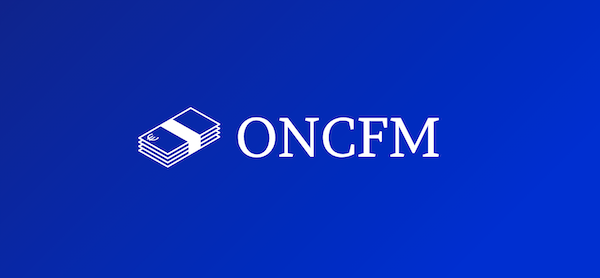

# **Introduction**

**Auteur** = Lauren GUIOT

**Date** = 19/06/23

L'ONCEFM a besoin d'un algorithme qui permet de détecter les faux billets à partir des dimensions géométriques des billets.

Ce notebook explore donc les différentes mesures afin de trouver l'algortihme qui détectera le plus efficacement possibles les potentiels futurs faux billets.

Objectif du projet: 
 * Réaliser une analyse prédictive
 * Réaliser une régression logistique
 * Réaliser une régression linéaire
 * Opérer des classifications automatiques pour partitionner les données

# Sommaire <a class="anchor" id="sommaire"></a>
* [I. Importation](#I)
* [II. Exploration de données](#II)
  * [a. Analyse Forme](#II.1)
       * [Format](#II.1.1)
       * [Type de données](#II.1.2)
       * [Données Manquantes](#II.1.3)
  * [b. Analyse Fond](#II.2)
       * [Target](#II.2.1)
       * [Features](#II.2.2)
       * [Relation Target-Features](#II.2.3)
       * [Identifier les Outliers](#II.2.4)
  * [C. Test de 3 Hypothèses](#II.3)
       * [Préparation pour test](#II.3.1)
       * [H1 Margin_low influence billet](#II.3.2)
       * [H2 length influence billet](#II.3.3)
       * [H3 Dépendance entre Length et Margin_low](#II.3.4)
       * [Test autres variables](#II.3.5)
* [III. Preprocessing](#III)
   * [1. préparation du dataset](#III)
        * [1. Split les données](#III.1)
        * [2. Affectation des colonnes](#III.2)
        * [3. Séparation Features X de la Target Y](#III.3)
   * [4. preprocessing](#III.4)
      * [Target](#III.4.1)
      * [Features](#III.4.2)
        * [Regression Linéaire sous](#III.4.2.a)
           * [Apprentissage et test](#III.4.2.a.1)
           * [Hypothèse à valider](#III.4.2.a.2)
        * [Regression Linéaire sous SKlearn pour optimiser](#III.4.2.b)
           * [Création modèle et optimisation](#III.4.2.b.1)
           * [Evaluation](#III.4.2.b.2) 
        * [Application de la Régression Linéaire](#III.4.2.c)          
* [IV. Analyse](#IV)
  * [A. Exploratoire ACP](#IV.1)
      * [1. Formules](#IV.1.1)
      * [2. Ebouli](#IV.1.2)
      * [3. Représentation variables](#IV.1.3)
        * [Axe 1-2](#IV.1.3.a)
        * [Axe 3-4](#IV.1.3.b)
      * [4. Représentation Individus](#IV.1.4)
  * [B. Apprentissage Non supervisé](#IV.2)
      * [Kmean](#IV.2.1)
        * [1. Choix nombre clusters](#IV.2.1.a)
        * [2. Application Kmeans](#IV.2.1.b)
        * [3. Centroïdes](#IV.2.1.c)
      * [Evaluation / associations](#IV.2.2)
  * [C. Apprentissage Supervisé](#IV.3)
      * [1. Création Pipelines Modèles](#IV.3.1)
      * [2. Cross Validation](#IV.3.2)
        * [Création CrossValidation](#IV.3.2.a)
        * [Evaluation des modèles](#IV.3.2.b)
      * [3. Optimisation avec GridSearch](#IV.3.3)
        * [Création de la GridSearch](#IV.3.3.a)
          * [Regression Logistique](#IV.3.3.a.i)
          * [K Nearest Neighbors](#IV.3.3.a.ii)
          * [Ridge Classifier](#IV.3.3.a.iii)
          * [Random Forest](#IV.3.3.a.iv)
        * [Trouver meilleurs Hyperparamètres](#IV.3.3.b)
      * [4. Choix Pipeline Finale](#IV.3.4)
        * [Pipeline sur Meilleur modèle](#IV.3.4.a)
          * [Création pipeline](#IV.3.4.a.i)
          * [Evaluation](#IV.3.4.a.ii)
          * [Learning curve](#IV.3.4.a.iii)
          * [Erreur](#IV.3.4.a.iv)
        * [Pipeline sur modèle demandé](#IV.3.4.b)
          * [Création pipeline](#IV.3.4.b.i)
          * [Evaluation](#IV.3.4.b.ii)
          * [Learning curve](#IV.3.4.b.iii)
          * [Erreur](#IV.3.4.b.iv)
* [V. Prédictions](#V)
  * [Importation nouveau Jeu de données](#V.1)
  * [Prédiction sur nouveau jeau de données](#V.2)
    * [Sur Kmeans](#V.2.a)
    * [Sur Modèle Machine learning](#V.2.b)



# <a class="anchor" id="I"></a> I. Importation

In [171]:
#!pip install pandas_profiling
#!pip install pingouin
#!pip install missingno
#!pip install yellowbrick

In [172]:


import pandas as pd
import numpy as np
import seaborn as sns  ; sns.set()                           # v 0.11.0
import matplotlib.pyplot as plt


# Preprocession
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, PowerTransformer, QuantileTransformer
from sklearn.pipeline import make_pipeline, Pipeline
import missingno as mno
#from pandas_profiling import ProfileReport


# ACP et Kmeans
from sklearn import decomposition
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# analyse Bivarié et inférentielle
import scipy.stats as st
from scipy.stats import  kstest, ranksums, t, shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pingouin as pg # pour la fonction corrélation partielle


# Modèles
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LinearRegression, RidgeClassifier, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error,mean_absolute_error, r2_score 
from statsmodels.tools import add_constant  
from statsmodels.api import Logit       # Régression Logistique


import pickle    # sauvegarder l'apprentissage
import warnings

In [173]:
df = pd.read_csv("billets.csv", sep=";"  )
df.head(1)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83


In [174]:
df.tail(1)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


* [sommaire](#sommaire)

# <a class="anchor" id="II"></a> II. Exploration de Données

**Objectif** = Identifier un faux billet à partir de ses caractéristiques géométriques.

**Mesure de performance** = Sensibilité Recall specificity.
* on veut réduire au maximum le taux de Faux Positifs donc de Faux billets prédits en Vrai billets.

**Target** = is_genuin
 * True (1000)
 * False (500)

**Features** = 6 ->
  * diagonal,
  * height_left,
  * height_right,
  * margin_low,
  * margin_up,
  * length


##  <a class="anchor" id="II.1"></a> Analyse Forme

###   <a class="anchor" id="II.1.1"></a> **Format**

In [175]:
df.shape

(1500, 7)

On a 1500 Billets mesurés et 7 variables.

###    <a class="anchor" id="II.1.2"></a> Types de données

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Ma target est au format Booléenne. Catégorique
=> Il faudra l'adapter au format numérique

Mes features sont au format Float.

###    <a class="anchor" id="II.1.3"></a> Données Manquantes

In [177]:
df.duplicated().sum() # pour vérifier les doublons

0

Nous n'avons pas de doublons dans le jeu de données

In [178]:
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

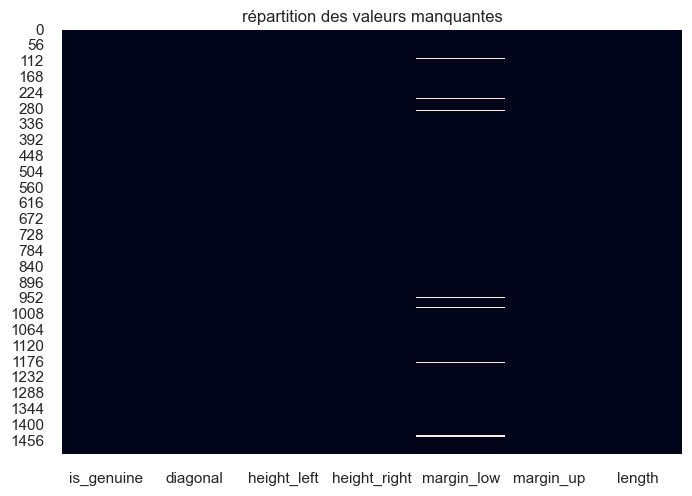

In [179]:
sns.heatmap(df.isna(), cbar=False)
plt.title("répartition des valeurs manquantes")
plt.show()

Il y a très peu de données manquantes dans le jeux de données. seul 37 valeurs de la variable Margin_low sont manquantes.

In [180]:
df[df["margin_low"].isna()]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


In [181]:
df[df["margin_low"].isna()].groupby("is_genuine").count()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,8,8,8,0,8,8
True,29,29,29,0,29,29


Ces valeurs manquantes concernent à la fois les faux et les vrai billets sans distinctions

* [sommaire](#sommaire)

##  <a class="anchor" id="II.2"></a> Analyse Fond

In [182]:
#ProfileReport(df, title= 'Profiling report', html={'style':{'full_width':True}})

###    <a class="anchor" id="II.2.1"></a> Target

In [183]:
df["is_genuine"].value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

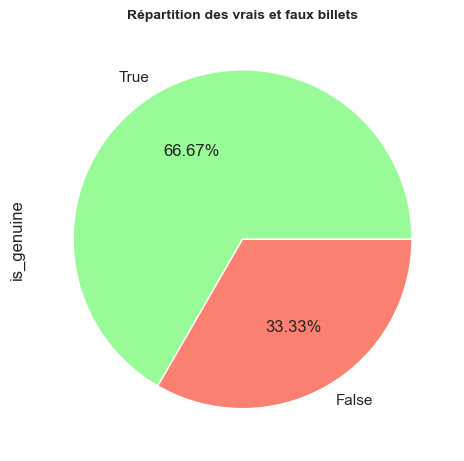

In [184]:
df["is_genuine"].value_counts(normalize=True).plot.pie(colors= ['palegreen', 'salmon'],
            autopct = lambda x: str(round(x, 2)) + '%') #Rajout des étiquettes valeurs
plt.title("Répartition des vrais et faux billets",
            fontsize = 10, fontweight="bold");

Les vrais billets représentent 66% du jeu de données et les faux billets 33% du jeu de données.
La représentation entre les 2 groupes n'est pas équilibrée

###     <a class="anchor" id="II.2.2"></a> Visualiser les Features
*  **Lenght**: Longueur du billet (mm)
*  **height_left** : la hauteur du billet (mesurée sur le côté gauche, mm) ;
* **height_right** : la hauteur du billet (mesurée sur le côté droit, en mm) ;
* **margin_up** : marge entre bord supérieur billet & image de celui-ci (en mm) ;
* **margin_low** : marge entre bord inférieur du billet et l'image de celui-ci (en mm) ;
* **diagonal** : la diagonale du billet (en mm).


In [185]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


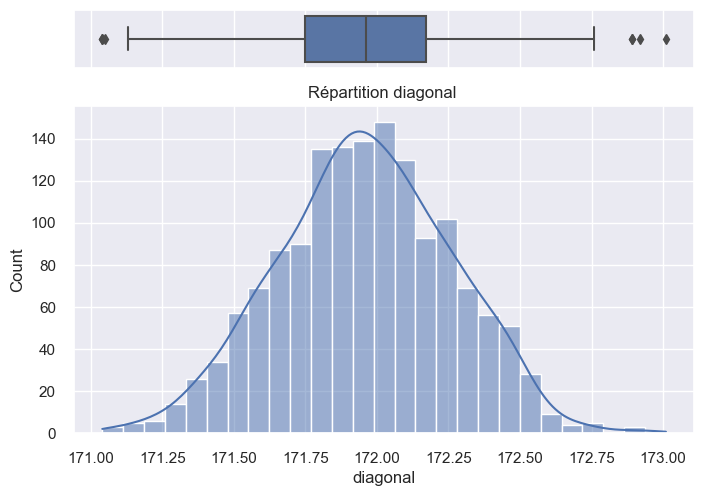

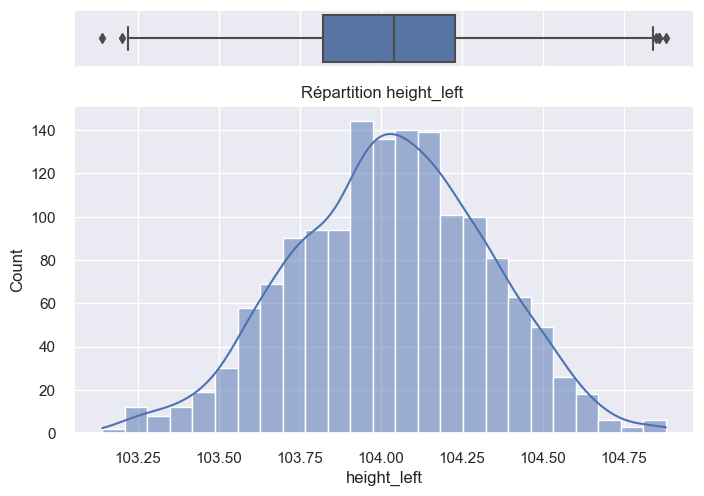

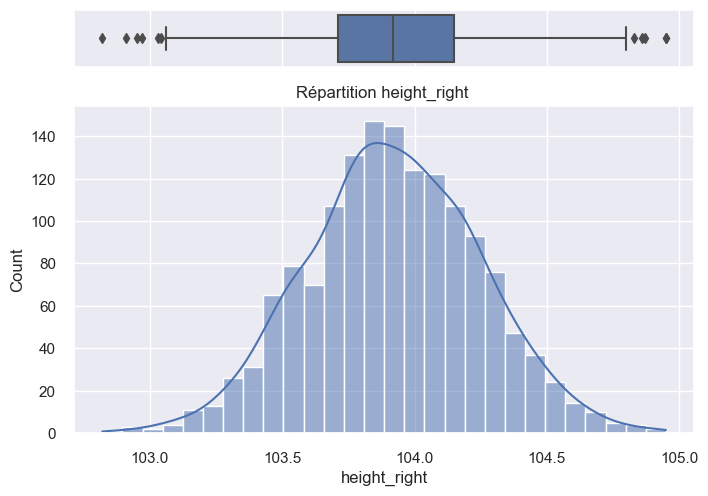

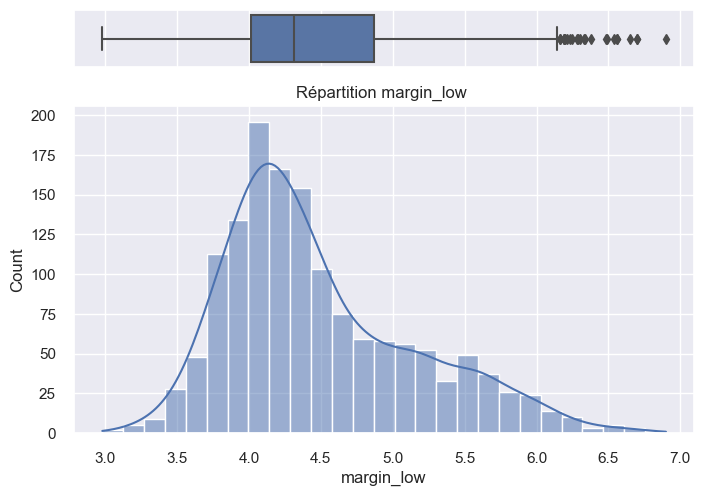

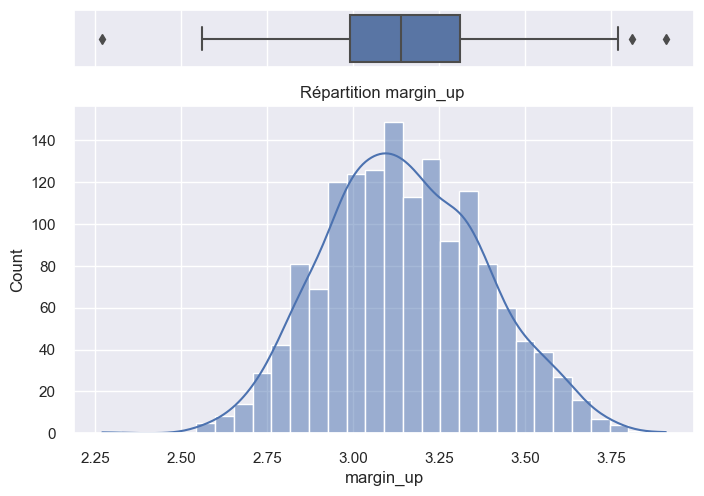

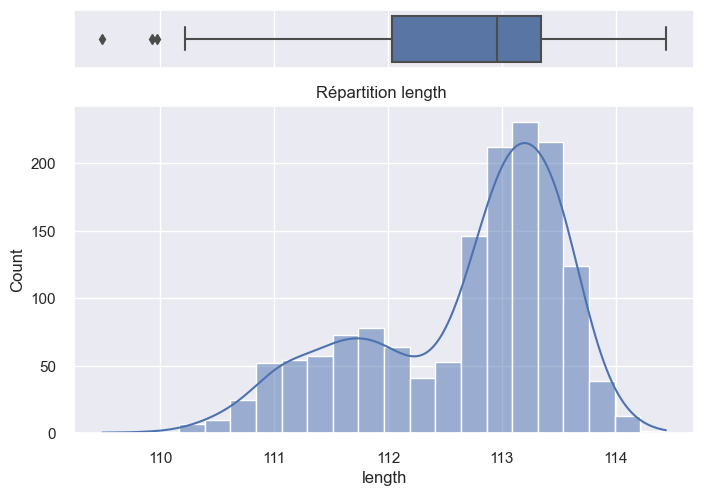

In [186]:
for i in df.select_dtypes('float'): # Graphique sur toutes les variables de types float pour exclure is_genuine
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios":(.15, .85)})
    sns.boxplot(data= df, x= i, ax=ax_box) # Boxplot
    sns.histplot(data= df, x= i, ax=ax_hist, kde= True) #Histogramme
    plt.title(f"Répartition {i} ")
    ax_box.set(xlabel="")

La distribution de la variable **diagonale** semble suivre une distribution normale avec peu d'outliers en début de distribution et en fin de distribution.

La distribution de la variable **height_left** semble elle aussi suivre une distribution normale avec peu d'outliers en début de distribution et en fin de distribution.

La distribution de la variable **height_right** semble elle aussi suivre une distribution normale cependant elle a plus d'outliers en début de distribution et en fin de distribution.

La distribution de la variable **margin_low**ne semble pas suivre distribution normale. Sa distribution semble plus étalée sur la droite avec de nombreux outliers sur la droite.

La distribution de la variable **margin_up** semble suivre distribution assez normale avec peu d'outliers en début de distribution et en fin de distribution.

La distribution de la variable **margin_low**ne semble pas suivre distribution normale. Sa distribution semble plus étalée sur la gauche avec de nombreux outliers sur la gauche.

In [187]:
print("skew: \n",df.skew(),"\n\nkurtosis: \n", df.kurtosis())

skew: 
 is_genuine     -0.707815
diagonal       -0.033307
height_left    -0.092121
height_right   -0.000328
margin_low      0.863066
margin_up       0.145938
length         -0.815957
dtype: float64 

kurtosis: 
 is_genuine     -1.501001
diagonal       -0.125284
height_left    -0.195271
height_right   -0.027232
margin_low      0.223886
margin_up      -0.245076
length         -0.280325
dtype: float64


Diagonale, height_left,height_right :
  * Skewness quasi symétrique proche de 0
  * Kurtosis suit une distribution quasi normale proche de 0

margin_low:
  * Skewness très étalée sur la droite > 0
  * Kurtosis plutôt concentrée avec une distribution moins aplatie  > 0

margin_up:
  * Skewness très légèrement étalée sur la droite > 0
  * Kurtosis moins concentrée avec une distribution un peu plus aplatie < 0

length:
  * Skewness très étalée sur la gauche < 0
  * Kurtosis moins concentrée avec une distribution un peu plus aplatie < 0

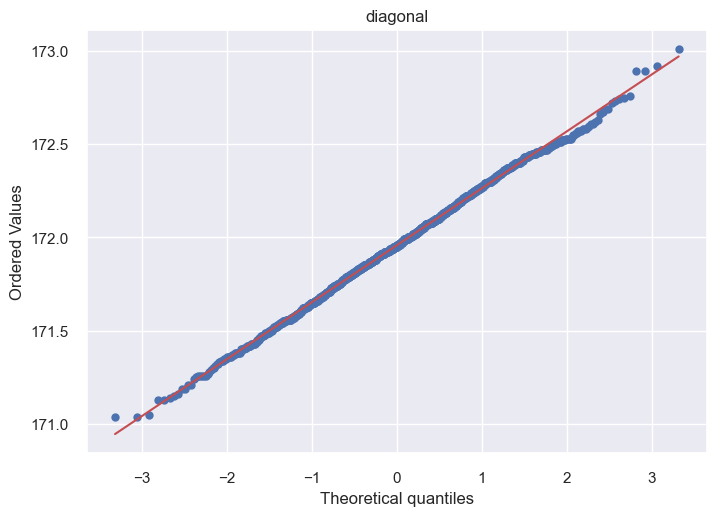

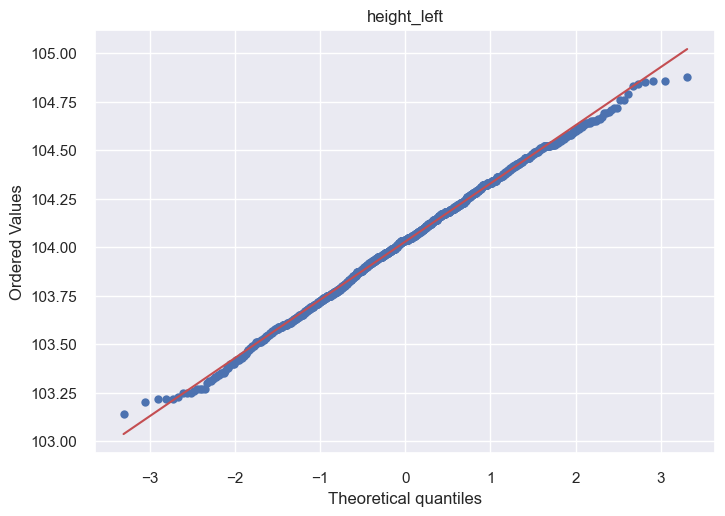

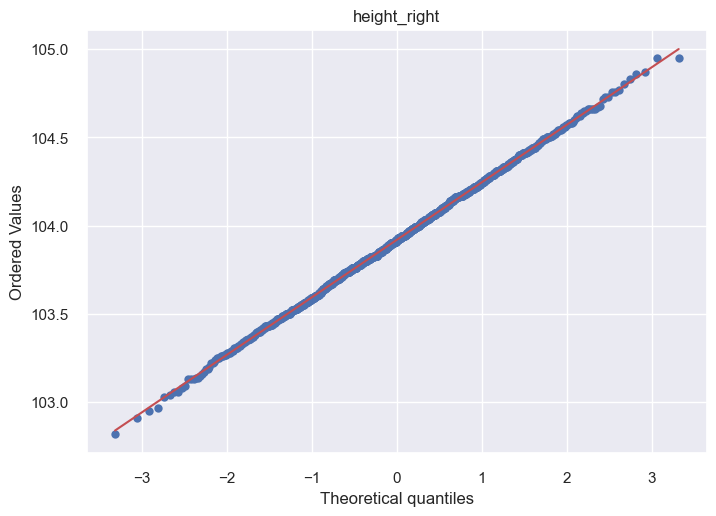

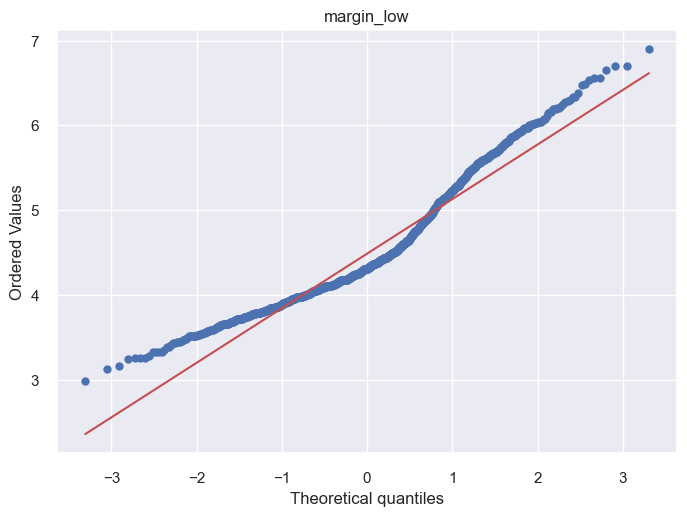

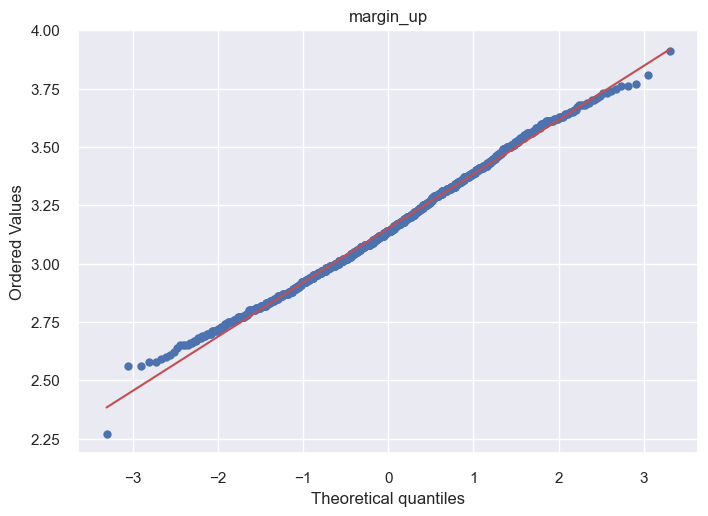

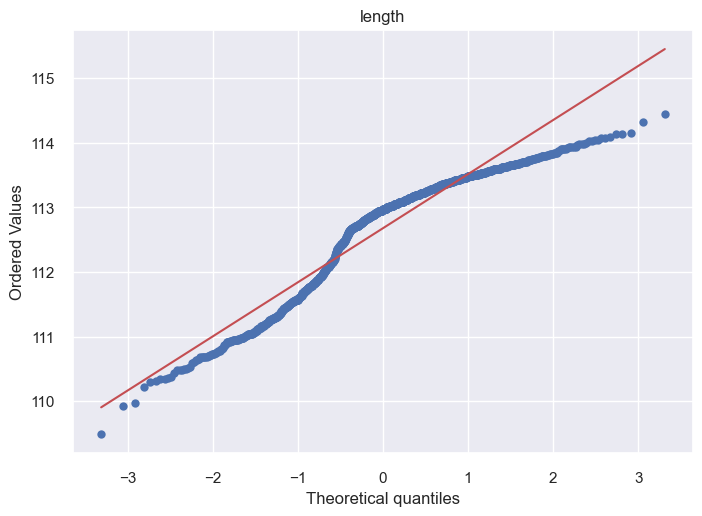

In [188]:
for i in df.select_dtypes('float'):
  st.probplot(df[i].dropna(), dist='norm', plot= plt)
  plt.title(i)
  plt.show()

On confirme que la variable Length et Margin_low ne suivent pas une distribution normale au vu de la courbe théorique du Q-Q plot qui ne suit pas la distribution réelle de la variable.

In [189]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Il ne semble pas y avoir d'incohérence dans les différentes mesures géométriques des variables en comparant les valeurs minimum avec les valeurs maximums. La Variance semble faible. Elle est légèrement plus importante pour les variables Margin_low et length.

* [sommaire](#sommaire)

###    <a class="anchor" id="II.2.3"></a>  Relation entre Target et Features

distribution et relation entre les variables


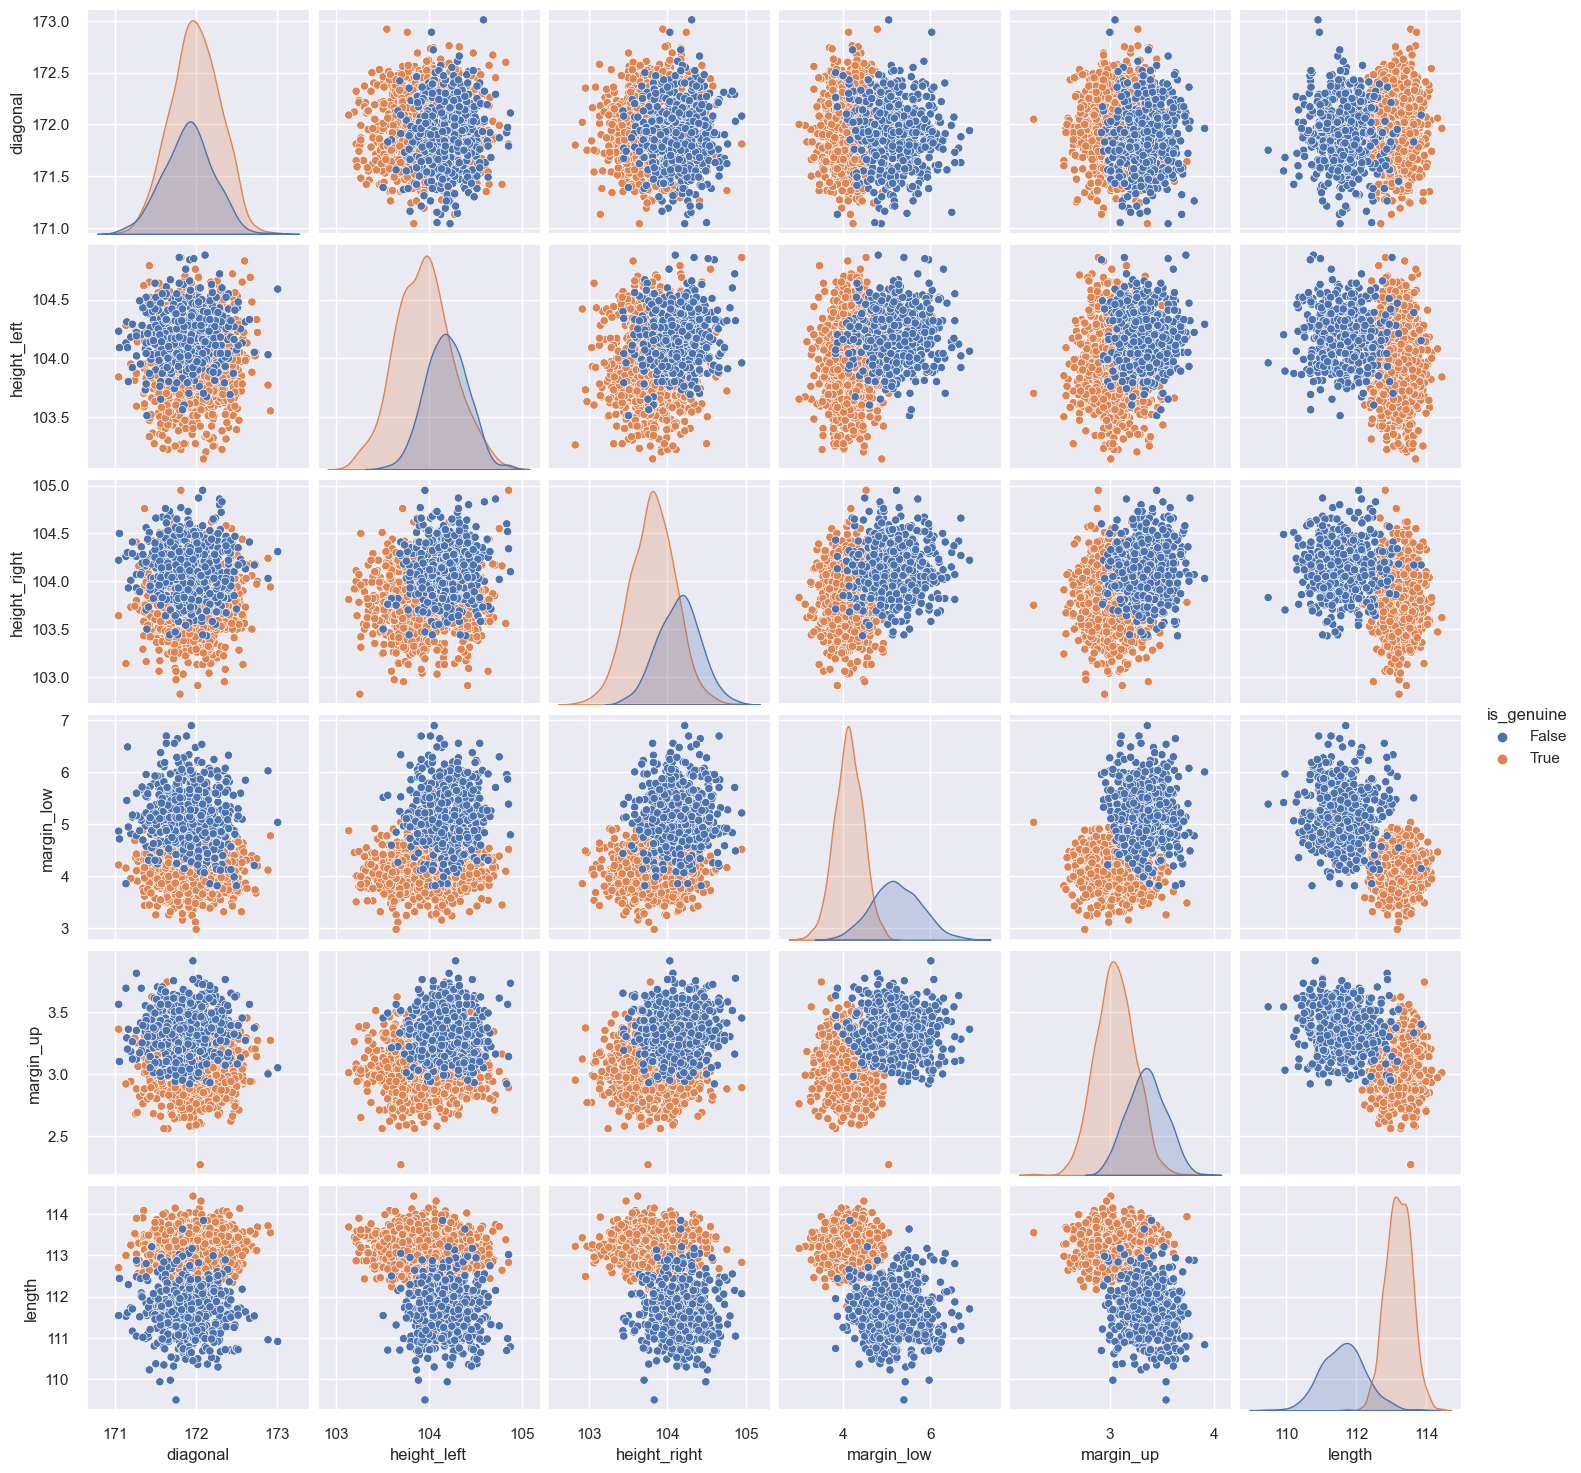

In [190]:
print("distribution et relation entre les variables")
sns.pairplot(df, hue="is_genuine")
plt.show()

Il ne semble pas y avoir de distinction entre les faux et les vrais billets au niveau de la mesure de la **diagonale**.

Les mesures de la **Margin_low** semblent plus grandes sur les faux billets que sur les vrais billets.

Les mesures de la **Length** semblent plus petites sur les faux billets que sur les vrais billets.

Les mesures de la **Margin_up**, **height_right** et **height_left** semblent légèrement plus grandes sur les faux billets que sur les vrais billets.

lorsqu'on compare la répartition des faux billets et des vrais billets on remarque qu'elles sont peu distinctes entre les différentes variables. On ne distingues pas vraiment de corrélation hormis au niveau de la variable length et margin_low où la distinction semble un peu plus "nette".

Text(0.5, 1.0, 'Heatmap des corrélations')

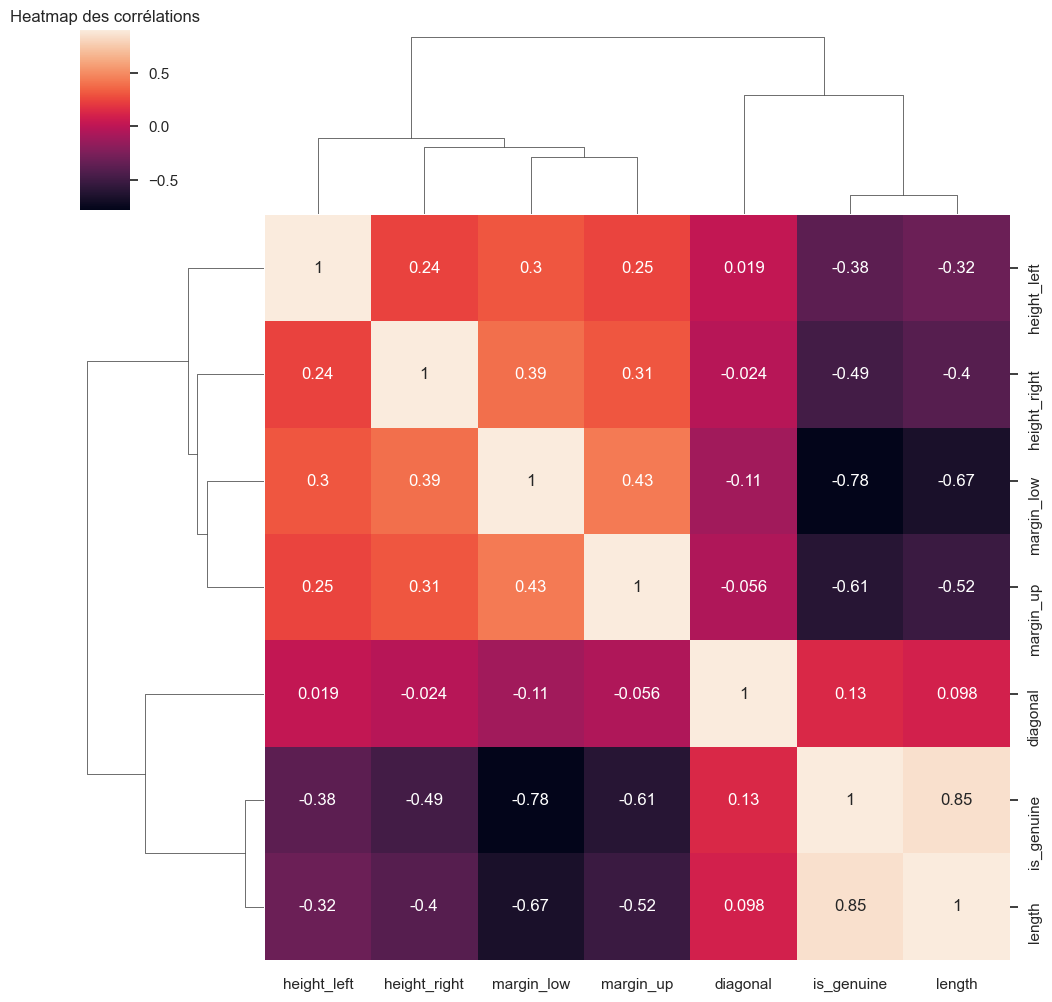

In [191]:
sns.clustermap(df.corr(), vmax=0.9, square=True,annot=True)
plt.title('Heatmap des corrélations')

Text(0.5, 1.0, 'Heatmap des corrélations partielles sans is_genuine')

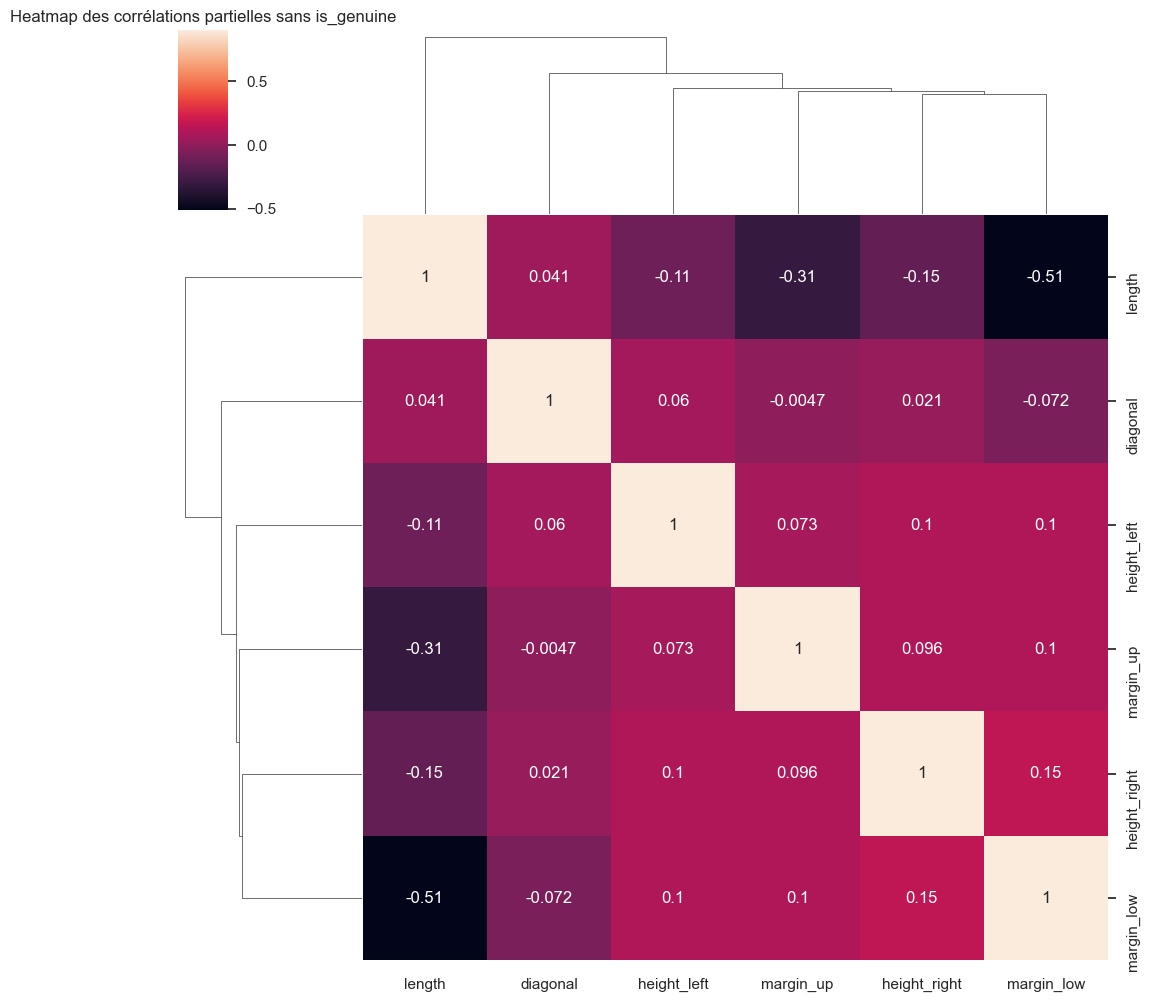

In [192]:
sns.clustermap(df.drop(columns="is_genuine", axis=1).pcorr(), vmax=0.9, square=True,annot=True)
plt.title('Heatmap des corrélations partielles sans is_genuine')

En se penchant plus sur les corrélations entre chaque variable, on distingue 3 fortes potentielles corrélations.
  * Entre la variable Length et l'authenticité du billet avec une corrélation positive à 0.85
  * Entre la variable margin_low et l'authenticité du billet avec une corrélation négative à -0.78
  * Entre la variable margin_low et la variable Length avec une corrélation négative à -0.67 voir -0.51 avec la corrélation partielle.

Les autres corrélations semblent moins fortes.

In [193]:
(st.spearmanr(df.is_genuine, df.length)[0]) **2  # Calcul coef corrélation R2

0.6245910415830171

Sachant que la variable Length ne suit pas une distribution normale, j'ai calculé le coefficient de corrélation de Spearman.
Son R2 semble également identifier une corrélation. 62% de la variation semble être expliquée par l'authenticité du billet.

* [sommaire](#sommaire)

###     <a class="anchor" id="II.2.4"></a> Identifier Outliers

In [194]:
df.std(ddof=0)

is_genuine      0.471405
diagonal        0.305093
height_left     0.299362
height_right    0.325519
margin_low      0.663586
margin_up       0.231736
length          0.872439
dtype: float64

In [195]:
# calcul afin de déterminer les valeurs minimum et maximum pour identifier les valeurs dépassant la limite
IQ = df.select_dtypes('float').quantile(0.75)-df.select_dtypes('float').quantile(0.25)  # calcul ecart Interquartile
Min= df.select_dtypes('float').quantile(0.25) -(1.5*IQ) # détermine la valeur minimum. tout ce qui est en dessous est considéré comme outlier
Max= df.select_dtypes('float').quantile(0.75)+(1.5*IQ) # détermine la valeur maximum. tout ce qui est au dessus est considéré comme outlier
Min

diagonal        171.1200
height_left     103.2050
height_right    103.0500
margin_low        2.7325
margin_up         2.5100
length          110.0650
dtype: float64

In [196]:
for i in df.select_dtypes('float').columns:
  print(i,"Outliers Min", df[df[i]<=Min[i]].shape)
  print(df[df[i]<=Min[i]])
  print(" \n")
  print(i,"Outliers Max", df[df[i]>=Max[i]].shape)
  print(df[df[i]>=Max[i]])
  print(" \n \n \n")

diagonal Outliers Min (3, 7)
      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
729         True    171.04       103.84        103.64        4.22       3.36   
1142       False    171.04       104.23        104.22        4.87       3.56   
1388       False    171.05       104.09        104.50        4.72       3.10   

      length  
729   112.70  
1142  111.54  
1388  112.44  
 

diagonal Outliers Max (4, 7)
      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
828         True    172.92       103.55        103.94        4.78       3.27   
842         True    172.89       103.77        104.24        4.12       3.01   
1022       False    172.89       104.03        104.03        6.03       3.00   
1277       False    173.01       104.59        104.31        5.04       3.05   

      length  
828   113.55  
842   113.72  
1022  110.95  
1277  110.91  
 
 
 

height_left Outliers Min (2, 7)
     is_genuine  diagonal  height_left  hei

On constate que les outliers concernent surtout les faux billets notamment au niveau des valeurs au-dessus du maximum.


J'ai décidé de ne pas supprimer les outliers détectés car risquent de trop réduire le dataset côté Faux billets. C'est potentiellement ces données outliers qui permettront d'identifier les faux billets.

* [sommaire](#sommaire)

##   <a class="anchor" id="II.3"></a> 1eres Hypothèses =

Relations marquantes identifiés ci-dessus :
* Margin_low semblent plus grandes sur les faux billets
*   Length semblent plus petites sur les faux billets

* Margin_up, height_right et height_left semblent légèrement plus grandes sur les faux billets.

* forte corrélation entre Length et l'authenticité du billet
* Corrélation négative entre Length et Margin_low, suivi de Margin_up
* forte corrélation négative entre margin_low et l'authenticité du billet.
* une assez forte corrélation négative entre les margin_up et l'authenticité des billets.

Hypothèses:
* Les faux billets ont une Margin_low significativement différentes des vrais billets.
> *   H0 = La mesure moyenne des Margin_low est identique entre les faux billets et les vrais billets
* Les faux billets ont une Length significativement différentes des vrais billets.
> *   H0 = La mesure moyenne des Length est identique entre les faux billets et les vrais billets

* La mesure du Length est significativement liée avec la mesure du margin_low.
> * H0 = Les 2 variables sont indépendantes



###     <a class="anchor" id="II.3.1"></a> Préparation pour tester les hypothèses

In [197]:
# pour avoir un échantillon équilibré le nombre de billet entre les vrai et faux billets
# j'ai supprimé les lignes avec NaN car ils sont peu nombreux et n'influenceront pas les test
Faux = df.dropna()[df["is_genuine"]==0]                                # table avec juste faux billets sans NaN
Echanti_vrai = df.dropna()[df["is_genuine"]==1].sample(Faux.shape[0])  # table avec Echantillon vrai billets sans NaN
echantiVF = pd.concat([Echanti_vrai, Faux])

In [198]:
print(df.dropna()[df["is_genuine"]==1].shape, Faux.shape,Echanti_vrai.shape)

(971, 7) (492, 7) (492, 7)


Nous avons maintenant 492 faux billet et 492 vrai billets pour appliquer notre test inférenciel sur nos différentes hypothèses.

In [199]:
# Variance pour chaque groupe
Echanti_vrai.std(), Faux.std()

(is_genuine      0.000000
 diagonal        0.288776
 height_left     0.302068
 height_right    0.293973
 margin_low      0.324494
 margin_up       0.188204
 length          0.354929
 dtype: float64,
 is_genuine      0.000000
 diagonal        0.305473
 height_left     0.224418
 height_right    0.271683
 margin_low      0.553531
 margin_up       0.179343
 length          0.615343
 dtype: float64)

On remarque que la variance est semblable pour chaque variable entre les vrais et les faux billets. Seules les variables margin_low et length ont une variance différence.

In [200]:
# Création des formules à appliquer
def testnParam(col):  # Test Non paramétrique de Wilcoxon
  rank= ranksums(Echanti_vrai[col],
           Faux[col],alternative='two-sided' )
  return rank

def testnParam2(col): # Test non paramétrique de Mann-Whitney bilatéral
  rank= st.mannwhitneyu(x=echantiVF[col],
           y= echantiVF["is_genuine"],alternative='two-sided' )
  return rank

def testCorParam(col1, col2): # Test Paramétrique de Pearson
  coef_cor= st.pearsonr(echantiVF[col1],echantiVF[col2] )
  return coef_cor

def testCorNonParam(col1, col2): # Test Non Paramétrique de Spearman
  coef_cor= st.spearmanr(echantiVF[col1],echantiVF[col2],  )
  return coef_cor

* [sommaire](#sommaire)

###    <a class="anchor" id="II.3.2"></a> Hypothèse 1 Margin_low influence l'authenticité du billet

**le test de Wilcoxon-Mann-Whitney Bilateral.**
Le test de Wilcoxon Mesure l'écart de
position entre 2 Variables qui somme les rangs de chaque Variable (W).

* X = Margin_low transformé en vecteur de rangs
* Y = is_genuine qui est une variable binaire. groupe1 et groupe2

H0= les deux groupes g1 et g2sont semblables.


In [201]:
testnParam("margin_low")

RanksumsResult(statistic=-24.97110070316019, pvalue=1.2600037704288985e-137)

On constate que la P_value calculée est largement plus petite que 0.05. H0 est donc bien rejetée. Ce test Rejette donc bien l'indépendance entre ces 2 facteurs



---



**le test de Mann-Whitney Bilateral.**

* Le test de Mann Whitney Mesure l'écart entre les échantillons qui somme les nombres de couples.(U)


* X = Margin_low transformé en vecteur de rangs
* Y = is_genuine qui est une variable binaire. groupe1 et groupe2

H0= les deux groupes sont semblables.

In [202]:
testnParam2("margin_low")

MannwhitneyuResult(statistic=968256.0, pvalue=0.0)

On constate que la P_value calculée est également largement plus petite que 0.05. H0 est donc bien rejetée. Ce test Rejette donc bien l'indépendance entre la mesure margin_low et l'authenticité du billet.

Il sera donc essentiel de remplacer les valeurs manquantes par des valeurs cohérentes qui ne risquent pas de fausser l'analyse et la prédiction

* [sommaire](#sommaire)

###    <a class="anchor" id="II.3.3"></a> Hypothèse 2 Test Length influence l'authenticité du billet

In [203]:
testnParam("length")

RanksumsResult(statistic=26.35101823386425, pvalue=4.99633670436261e-153)

In [204]:
testnParam2("length")

MannwhitneyuResult(statistic=968256.0, pvalue=0.0)

On constate que la P_value calculée dans le test de Wilcoxone et MannWhitney sont largement plus petites que 0.05. H0 est donc bien rejetée. Ces tests Rejettent donc bien l'indépendance entre la mesure length et l'authenticité du billet. Il y aurait donc une potentielle relation entre la mesure du length et l'authenticité du billet.

* [sommaire](#sommaire)

###   <a class="anchor" id="II.3.4"></a>  Hypothèse 3 Test Dépendance entre Length et Margin_low

**le test de Spearman.**

* Le test étudie la relation monotone entre 2 variables qui ne suivent pas une distribution normale.


* X1 = Margin_low
* X2 = Length

H0= les deux groupes sont indépendantes.

In [205]:
testCorNonParam("margin_low","length")

SignificanceResult(statistic=-0.6700224799279211, pvalue=3.248029531201645e-129)

On constate que la P_value calculée dans le test est largement plus petite que 0.05. H0 est donc bien rejetée. Ces tests Rejettent donc bien l'indépendance entre la mesure length et la mesure Margin_low.

In [206]:
for i in df.drop(columns=["is_genuine", "length", "margin_low"], axis=1).columns: # Variables avec distribution normales
  print(testCorNonParam("margin_low",i), "est le test avec la variable",i)


SignificanceResult(statistic=-0.12206699316283891, pvalue=0.0001237439374319039) est le test avec la variable diagonal
SignificanceResult(statistic=0.3529037908251306, pvalue=3.1105063080251506e-30) est le test avec la variable height_left
SignificanceResult(statistic=0.41405337144182425, pvalue=4.82642785334293e-42) est le test avec la variable height_right
SignificanceResult(statistic=0.4694963058886197, pvalue=4.3086154638336095e-55) est le test avec la variable margin_up


Vu que la variable Margin_low possède des Valeurs manquantes, j'ai vérifié la corrélation avec les autres variables. On constate que la P_value calculée dans le test est largement plus petite que 0.05. H0 est donc bien rejetée. Ces tests Rejettent donc bien l'indépendance entre la mesure Margin_low et les autres variables. Mais le coefficient de détermination reste faible.

* [sommaire](#sommaire)

###   <a class="anchor" id="II.3.5"></a>  Test des autres Variables Paramétriques sur l'authenticité du billet


**le test de Student.**

Le test compare la moyenne entre 2 séries.

**Conditions**:
* Les mesures sont indépendantes
* Les échantillons ont des variances égales
* Au moins 20 individus par échantillon ou normalité des populations de chaque échantillon supposée ou vérifiée
* X= continue
* Y = Binaire Is_ganuine

H0= les deux groupes sont indépendantes.


**Etape 2**:
Déterminer le degré de liberté:
982

**Etape 3**:
Choisir le seuil d'erreur 0.0001

**Etape 4**:
Déterminer le T critique suivant la table de la loi de STUDENT = 3.906

**Etape 5**: Calcul du T calculé et de la P_value
exemple Diagonal T= 4.014 et P>|t|= 0.000

In [207]:
# Test de Student
for i in df.drop(columns=["is_genuine", "length", "margin_low"], axis=1).columns: # Variables avec distribution normales
  f = i + " ~ " + "is_genuine"
  model= smf.ols(f, data=echantiVF )
  print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               diagonal   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     17.88
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           2.57e-05
Time:                        22:18:26   Log-Likelihood:                -201.44
No. Observations:                 984   AIC:                             406.9
Df Residuals:                     982   BIC:                             416.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            171.9014      0

Si on convertie la valeur de T en absolue, on remarque qu'elle est toujours plus grande que le T critique à 3.906.
De plus la P_value est largement plus petite que 0.0001. donc on peut rejetée H0 pour toutes les variables.
Elles auraient toutes une influence plus ou moins importante sur l'authenticité du billet.



---


**le test de Pearsonn.**

Le test mesure la qualité de la relation linéaire entre 2 variables.

**Conditions**:
* Chaque Variable suit une distribution normale
* Au moins 20 individus dans l'échantillon
* X1 et X2 même taille

H0= les deux groupes sont indépendantes.

In [208]:
# Test de Pearsonn
for i in ["diagonal", "height_left","height_right","margin_up"]: # Selection du X1
  for f in df.drop(columns=["is_genuine", "length", "margin_low",i], axis=1).columns: # Selection du X2
    print(i,f, "\n", testCorParam(f,i))

diagonal height_left 
 PearsonRResult(statistic=-0.01477389803658585, pvalue=0.6434537734808555)
diagonal height_right 
 PearsonRResult(statistic=-0.015897462691524537, pvalue=0.6184265765218501)
diagonal margin_up 
 PearsonRResult(statistic=-0.057484120651261995, pvalue=0.07148171716545132)
height_left diagonal 
 PearsonRResult(statistic=-0.01477389803658585, pvalue=0.6434537734808555)
height_left height_right 
 PearsonRResult(statistic=0.2572157933252508, pvalue=2.473131215130128e-16)
height_left margin_up 
 PearsonRResult(statistic=0.27963475662181114, pvalue=3.9063106600099957e-19)
height_right diagonal 
 PearsonRResult(statistic=-0.015897462691524537, pvalue=0.6184265765218501)
height_right height_left 
 PearsonRResult(statistic=0.2572157933252508, pvalue=2.473131215130128e-16)
height_right margin_up 
 PearsonRResult(statistic=0.3299610683989411, pvalue=2.0128099081966504e-26)
margin_up diagonal 
 PearsonRResult(statistic=-0.057484120651261995, pvalue=0.07148171716545132)
margin_u

On constate que les coefficients R2 de pearsonn restent assez faible entre les variables diagonal, height_left et right et margin_up. elles seraient entre -0.06 et 0.35.


=> Plus le coefficient se rapprohe de 0 plus la P_value augmente et se retrouve au dessus de 5%. On ne rejetera donc pas l'hypothèse 0 et confirme bien une potentielle indépendance entre la variable **Diagonal** et les variables suivantes:
* height_left
* height_right
* margin_up

=> Par contre concernant les autres variables hors Diagonal, la P_value etant plus faible que 5%, nous pouvons donc rejeté H0. Ce test confirme qu'il y aurait une faible corrélation entre les variables height_right et left et margin_up.

* [sommaire](#sommaire)

#   <a class="anchor" id="III"></a>  III. PREPROCESSING

## Préparation du DataSet

###   <a class="anchor" id="III.1"></a>  Split des données

J'ai séparé les données en 2 groupes afin de pouvoir entrainer l'algorithme sur un train set puis je testerai son efficacité sur le testset.

In [209]:
trainset, testset= train_test_split(df, test_size= 0.2, random_state=0)

J'ai demandé que mon testset contienne 20% des données.

In [210]:
trainset.is_genuine.value_counts(normalize=True)

True     0.664167
False    0.335833
Name: is_genuine, dtype: float64

In [211]:
trainset.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      33
margin_up        0
length           0
dtype: int64

In [212]:
testset.is_genuine.value_counts(normalize=True)

True     0.676667
False    0.323333
Name: is_genuine, dtype: float64

In [213]:
testset.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      4
margin_up       0
length          0
dtype: int64

La proportion entre les vrai et les faux billets est quasiment identique entre mon groupe d'entrainement et mon groupe de test.

In [214]:
trainset.shape, testset.shape

((1200, 7), (300, 7))

Mon train set contient donc 1200 billets et mon test set 300 billets.

* [sommaire](#sommaire)

###  <a class="anchor" id="III.2"></a>   Affectation des Variables

In [215]:
# Définir les colonnes
target = ["is_genuine"]               # la target
drop_col =["id", "is_genuine"]                      # supprimer des variables
features = ["diagonal", "height_left", "height_right", "margin_up","length"] # Variables sans preprocessing

# preprocessing à faire
numNaN = ["margin_low"]               # Variables numériques avec NaN

Seules les variables Margin_low et is_genuine auront besoin d'un preprocessing afin de combler les NaN pour le Margin_low et encoder les valeurs pour la target.

* [sommaire](#sommaire)

###  <a class="anchor" id="III.3"></a>   Séparer Features X de la Variable Target y

In [216]:
X = trainset.drop(["is_genuine"], axis ='columns')
X_test = testset.drop(["is_genuine"], axis ='columns')

In [217]:
Y = trainset[['is_genuine']]
Y_test = testset[['is_genuine']]
X.shape, Y.shape

((1200, 6), (1200, 1))

J'ai stocké les variables features dans la variable X et la target dans la variable Y pour le trainset et le testset.
Les dimensions entre X et Y sont identique concernant le nombre de lignes à 1200 pour le trainset et 300 pour le testset.

* [sommaire](#sommaire)

##  <a class="anchor" id="III.4"></a>   Preprocessing

###  <a class="anchor" id="III.4.1"></a>   Target

In [218]:
Target_encoder = LabelEncoder()
Target_encoder.fit_transform(np.array(Y).ravel())
Y= Target_encoder.transform(np.array(Y).ravel())  # Ravel pour modifier Dimension à (n,)
Y_test= Target_encoder.fit_transform(np.array(Y_test).ravel())
filename = 'encoder.sav'
pickle.dump(Target_encoder, open(filename,'wb'))

J'ai encodé la variable is_genuine afin de transformer les valeurs booléen en valeur numériques pour le trainset et le testset.

0 = False
1 = True

* [sommaire](#sommaire)

###  <a class="anchor" id="III.4.2"></a>    Features

####  <a class="anchor" id="III.4.2.a"></a>  Regression linéaire sous Statsmodel

#####  <a class="anchor" id="III.4.2.a.1"></a>    Apprentissage et test du Modèle de régression linéaire
- coefficient de Détermination
- significativité dans le modèle
  * Test Global de Fisher
  * Test pour chaque variable de Student et procédure itérative de Backward.

- Estimation des Moindres carrés Ordinaires


In [219]:
# Création du Modèle
scale = PowerTransformer(method="box-cox")
X_Scaled= pd.DataFrame(scale.fit_transform(X), columns=X.columns ) # Standardisation des données
X_Scaled = sm.add_constant(X_Scaled)  # Rajout d'une variable constante
supp = target+ numNaN # variables à ne pas prendre en compte. (Is_genuine et Margin_low)
null = X_Scaled.loc[X_Scaled["margin_low"].isnull()] # table avec que les valeurs manquantes
nonulls= X_Scaled.dropna() # Tables sans valeur manquantes
parameters= list(set(nonulls.columns) - set(supp))  # Variables permettant de prédire les valeurs manquantes
regressionM= sm.OLS(nonulls["margin_low"], nonulls[parameters]).fit()
print(regressionM.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     172.1
Date:                Tue, 20 Jun 2023   Prob (F-statistic):          4.39e-137
Time:                        22:18:26   Log-Likelihood:                -1332.3
No. Observations:                1167   AIC:                             2677.
Df Residuals:                    1161   BIC:                             2707.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0035      0.022     -0.156   

Le modèle d'apprentissage a été appliqué sur les 1167 billets qui n'ont pas de valeurs manquantes. 

Le Coefficient de détermination R2 est proche de 0.43 ce qui indique que 43% de la variation est expliquée par le modèle. 
Vu qu'il y avait très peu de corrélation entre les variables, ce score reste satisfaisant pour prédire les valeurs manquantes. 

Au niveau de la significativité pour établir l'interval de confiance, on constate que le test global de Fisher a sa H0 rejetée car la P_value est < 0.05 autour de 4.39e-137

Au niveau du test de significativité sur chaque variable avec le test de Student, on remarque que la variable diagonal est la moins significative car sa p_value est la plus élevée même si elle se trouve en dessous du seuil de 0.05. Nous n'avons donc pas besoin de procéder au Backward pour éliminer des variables. 


In [220]:
# Calcul de l'estilation es moindres carrés ordinaires (MCO)
pred = regressionM.predict(nonulls[parameters])
model_error = mean_squared_error(nonulls["margin_low"], pred) # calcul de la Moyenne au carré MCO 
model_error2 = mean_absolute_error(nonulls["margin_low"], pred) # Calcul de la Moyenne Absolue MCO

print(f"L'erreur moyenne au carré du modèle optimal est {model_error:.2f}mm")
print(f"L'erreur moyenne absolue du modèle optimal est {model_error2:.2f}mm ")
residu= nonulls["margin_low"] - pred

L'erreur moyenne au carré du modèle optimal est 0.57mm
L'erreur moyenne absolue du modèle optimal est 0.59mm 


In [221]:
df["margin_low"].min(), df["margin_low"].max(), df["margin_low"].std()

(2.98, 6.9, 0.6638126241773387)

En calculant l'estimateur des moindres carrés Ordinaires, on constate que l'erreur moyenne se trouve entre 0,57 et 0,59mm sur la variable Margin_low. Sachant que l'amplitude de cette variable est assez importante,  entre 2,98 et 6,9, l'erreur reste acceptable. 

[Text(0.5, 0, 'Margin_low après imputation')]

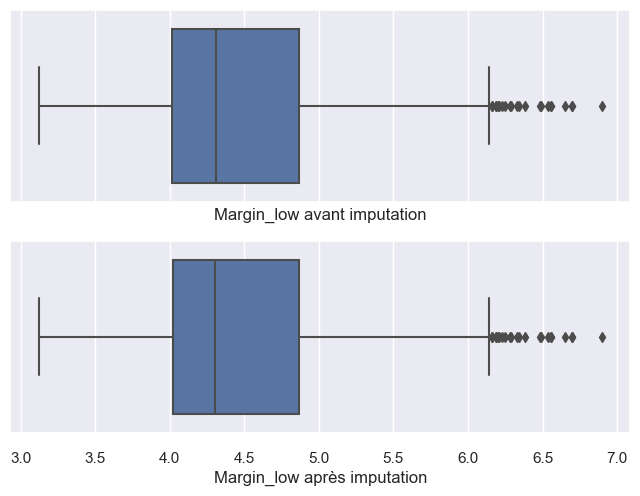

In [222]:
X_Scaled.loc[X_Scaled["margin_low"].isnull(), "margin_low"] = regressionM.predict(null[parameters]) # Prediction sur la table avec NaN
X_Scaled =X_Scaled.drop(columns="const", axis =1)
X_prep = pd.DataFrame(scale.inverse_transform(np.array(X_Scaled)), columns= X_Scaled.columns)

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios":(.15, .15)})
sns.boxplot(data= X, x= "margin_low", ax=ax_box) # Boxplot
sns.boxplot(data= X_prep, x= "margin_low", ax=ax_hist) #Boxplot 2
#plt.title("Répartition margin_low ")
ax_box.set(xlabel="Margin_low avant imputation")
ax_hist.set(xlabel="Margin_low après imputation")

On remarque qu'avec ou sans imputation, la distribution reste la même et cette imputation ne l'influence pas. Donc même si d'autres méthodes d'imputations seraient plus adaptées, nous pouvons conserver cette méthode car elle influence peu les valeurs. 

* [sommaire](#sommaire)

##### Analyse des influents et atycicité
- Variables explicatives (leviers des observations)
- Variables à expliquer (résidus studentisé)
- Observations (distance de Cook)

In [223]:
alpha= 0.01
n = nonulls.shape[0]
p = 4

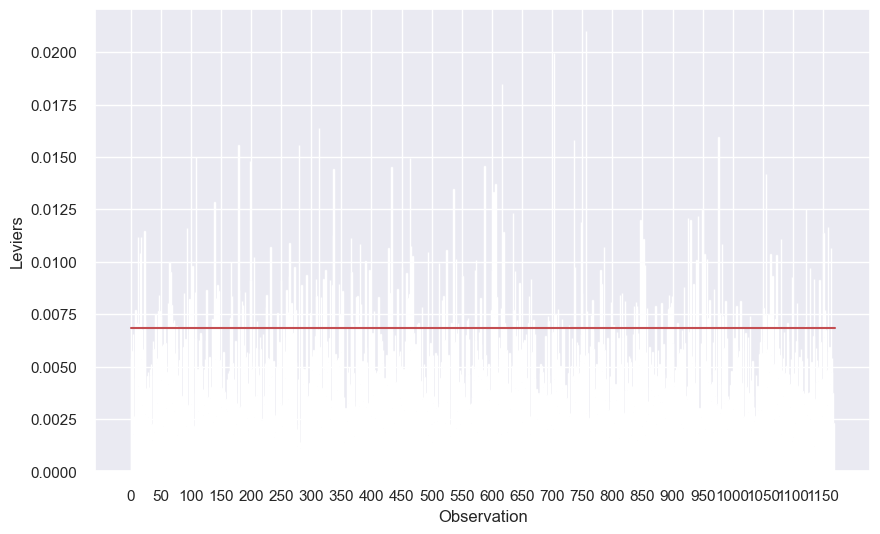

In [224]:
# LEVIERS
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['levier'] = regressionM.get_influence().hat_matrix_diag

seuil_levier = 2*p/n
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1170, step=50))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1170], [seuil_levier, seuil_levier], color='r')
plt.show()

In [225]:
analyses.loc[analyses['levier'] > seuil_levier, :].head(2)

,obs,levier
7,8,0.007706
9,10,0.007080


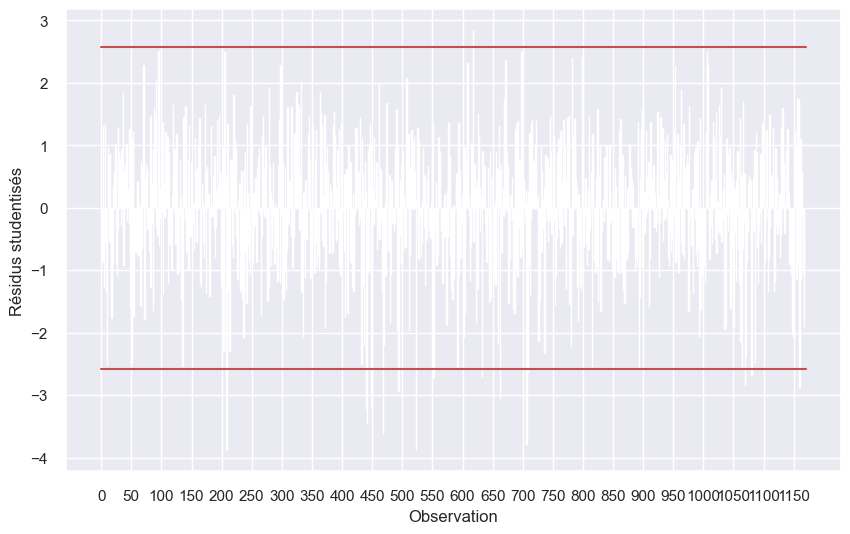

In [226]:
# Residus studentisé
analyses['rstudent'] = regressionM.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1170, step=50))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1170], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1170], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

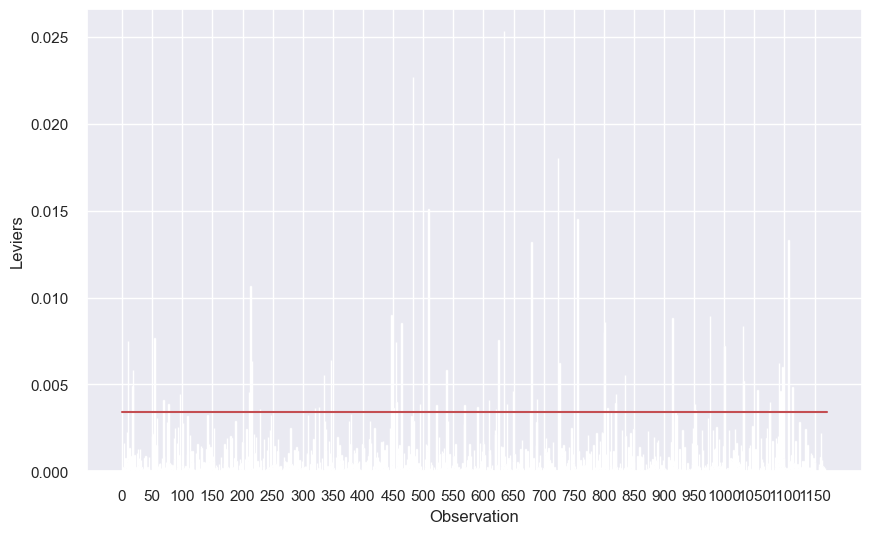

In [227]:
# Distance COOK
influence = regressionM.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1170, step=50))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1170], [seuil_dcook, seuil_dcook], color='r')
plt.show()

* [sommaire](#sommaire)

#####  <a class="anchor" id="III.4.2.a.2"></a>    Hypothèses à valider pour vérifier l'efficacité de la régression linéaire
- l'absence de multi-colinéarité au sein des variables
- l'indépendance des résidus entre eux
- l'exogénéité des variables explicatives ou l'indépendance entre elles et les résidus
- homoscédasticité des résidus (test de Breusch-Pajan) leur variance constante
- normalité des résidus (test de Jarque-Bera)

L'hypothèse la plus importante à valider est la 1ere. Les risques de biaisés les estimateurs. par expemple, si on a une corrélation au niveau des résidus, la régression risque de perdre en efficacité.

In [228]:
# vérifier colinéarité avant application de la régression inférieur à 10
D= nonulls.drop(columns=["const"],axis=1).columns
vif_data= pd.DataFrame()
vif_data["feature"]= D
vif_data["VIF"]= [variance_inflation_factor(nonulls.values, i) for i in range(len(D))]
vif_data

,feature,VIF
0,diagonal,1.000144
1,height_left,1.016104
2,height_right,1.151793
3,margin_low,1.263685
4,margin_up,1.741296
5,length,1.392027


In [229]:
# vérifier colinéarité après application de la régression
variables = regressionM.model.exog    # exog signifie "data" on extrait les valeurs de la table avec regression
[variance_inflation_factor(variables, i) for i in range(len(D))]

[1.0001225447401054,
 1.2276292674405036,
 1.5513128461304404,
 1.3728303177541383,
 1.01160672147582,
 1.141191947473515]

On constate que le Facteur d'inflation de la variance est en dessous de 10. On peut donc confirmer qu'il n'y a pas de multicolinéarité au sein des variables. 

In [230]:
#homoscédasticité Constance de la variance des résidus Pas rejeter H0
import statsmodels
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(regressionM.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.31888367602877465


p value test Breusch Pagan est largement au dessus de 0.05 avec une valeur à 0.318. On confirme donc bien l'hypothèse de la constance au sein des résidus 

In [231]:
# Normalité des résidus non rejeté
shapiro(regressionM.resid)

ShapiroResult(statistic=0.9879715442657471, pvalue=3.330546505253551e-08)

P Value du test de Shapiro est bien en dessous de 0.05 ce qui signifie que nous rejetons l'hypothèse de normalitée. 

Text(0.5, 1.0, 'distribution des residus')

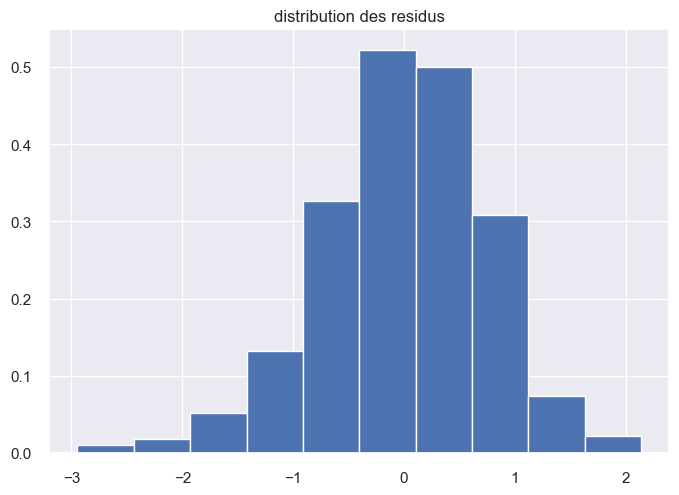

In [232]:
plt.hist(residu, density=True)
plt.title("distribution des residus")

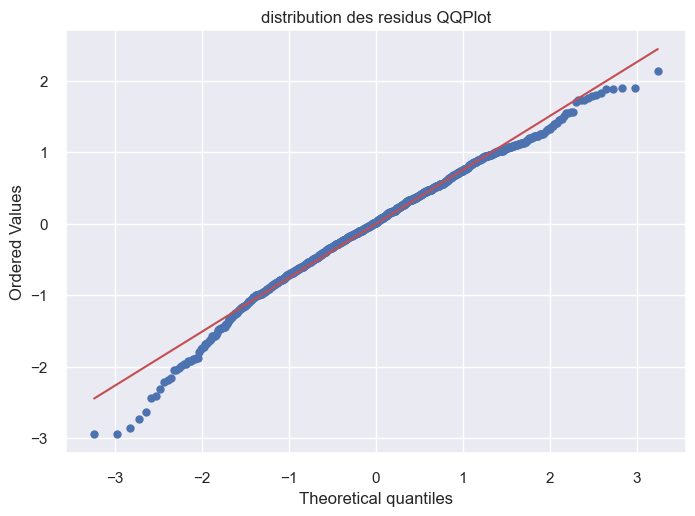

In [233]:
st.probplot(residu, dist='norm', plot= plt)
plt.title("distribution des residus QQPlot")
plt.show()

Mais en observant visuellement la distribution des résidus, elle se rapproche fortement d'une distribution normale hormis sur les extrèmités. De plus, le nombre de billets est important. Nous pouvons donc prendre en compte ces résidus dans notre modèle de régression linéaire. 

* [sommaire](#sommaire)

####  <a class="anchor" id="III.4.2.b"></a>  Optimiser Regression Linéaire sous Sklearn

#####  <a class="anchor" id="III.4.2.b.2"></a> Création du modèle et optimisation

In [234]:
# Création des paramètres
scale = PowerTransformer(method="yeo-johnson")
X_Scaled= pd.DataFrame(scale.fit_transform(X), columns=X.columns ) #standardisation des données
supp =  numNaN + target # suppression des variables non nécessaires
null = X_Scaled.loc[X_Scaled["margin_low"].isnull()] # rassembler toutes les billets avec valeurs manquantes
nonulls= X_Scaled.dropna() # Tables sans valeur manquantes
trains, tests= train_test_split(nonulls, test_size= 0.35, random_state=0) # Splits les variables avec un train set et un test set
parameters= list(set(nonulls.columns) - set(supp))  # Variables permettant de prédire les valeurs manquantes
X_rl= trains[parameters] # Features du train set
Y_rl = trains['margin_low'] # Target du train set

X_Trl = tests[parameters] # Features du test set
Y_Trl = tests['margin_low']  # Target du test set

In [235]:
# Optimisation de la régression Linéaire

model=  LinearRegression()
# Cross validation sur 5 groupes 
cv = KFold(n_splits= 5, shuffle=True,random_state=1)
# Choix des hyperparamètres à tester
param = {
  'fit_intercept':[True, False],
  'copy_X':[True, False],
  'n_jobs':[-1, None ],
  'positive': [True, False]
}

# Création de la Gridsearch
grid = GridSearchCV(model, param, scoring='r2', cv=cv)
# application de la grid search
result = grid.fit(X_rl, np.array(Y_rl))
print(result.best_params_) # ressort les meilleurs hyper paramètres
print(result.best_score_) # ressort le meilleur score.

{'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}
0.4142665678980471


* [sommaire](#sommaire)

#####  <a class="anchor" id="III.4.2.b.2"></a> Evaluation

In [236]:
result= LinearRegression(copy_X=True, fit_intercept=False,n_jobs=-1,positive=False).fit(X = X_rl, y= Y_rl)
pred_y = result.predict(X_rl)
#print("\tExplained variance:", explained_variance_score(nonulls["margin_low"], pred_y))
print("\tMean squared error:",mean_squared_error(Y_rl, pred_y))
print("\tMean absolute error:", mean_absolute_error(Y_rl, pred_y))
print("\tR2 score:", r2_score(Y_rl, pred_y))

	Mean squared error: 0.5740947104847324
	Mean absolute error: 0.5903737063885751
	R2 score: 0.4214591229489958


In [237]:
pred_y = result.predict(X_Trl)
print("\tMean squared error:",mean_squared_error(Y_Trl, pred_y))
print("\tMean absolute error:", mean_absolute_error(Y_Trl, pred_y))
print("\tR2 score:", r2_score(Y_Trl, pred_y))

	Mean squared error: 0.5722831263971846
	Mean absolute error: 0.5992534580822306
	R2 score: 0.43531594108546434


Grace à la grid Search, j'ai réussi à améliorer le R2 de 42.6 à 43.5. 
Le MCO s'améliore très légèrement. 
Je vais utiliser cette Regression linéaire pour remplacer les valeurs manquantes.

Text(0.5, 1.0, "courbe d'apprentissage de la régression Linéaire")

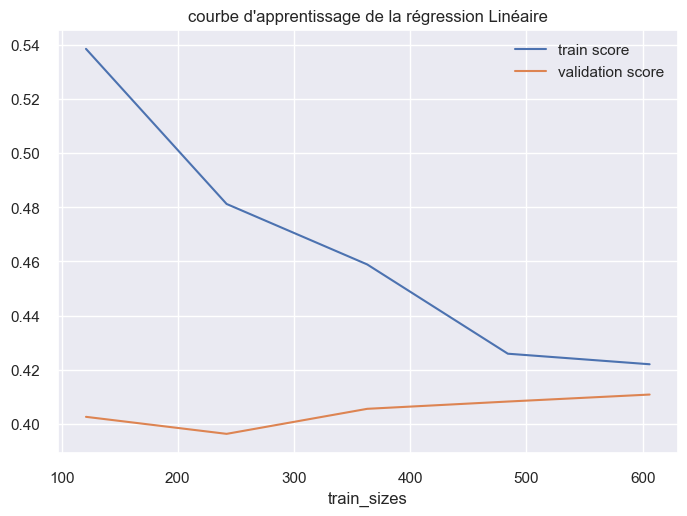

In [238]:
N, train_score, val_score = learning_curve(result, X_rl, Y_rl, scoring='r2', train_sizes=np.linspace(0.2, 1.0, 5), cv=5)
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.xlabel('train_sizes')
plt.legend()
plt.title("courbe d'apprentissage de la régression Linéaire")

* [sommaire](#sommaire)

####  <a class="anchor" id="III.4.2.c"></a>   Application Regression linéaire

In [239]:
def suppNaN (X):    # FONCTIONNE SUR LA PIPELINE DIRECT avec StatsModel
  warnings.filterwarnings('ignore')
  if X.isna().sum().sum()>0:
    scale = PowerTransformer(method="yeo-johnson")
    X_Scaled= pd.DataFrame(scale.fit_transform(X), columns=X.columns )
    X_Scaled = sm.add_constant(X_Scaled)  # Rajout d'une variable constante
#    X_Scaled = X.copy()
    supp = target+ numNaN
    parameters= list(set(X_Scaled.columns) - set(supp))  # Variables permettant de prédire les valeurs manquantes
    nonulls= X_Scaled.dropna() # Tables sans valeur manquantes
    for i in numNaN:
     null = X_Scaled.loc[X_Scaled[i].isnull()] # Tables avec valeur manquantes
     model = sm.OLS(nonulls[i], nonulls[parameters])
     result= model.fit()  # Modèle apprentissage sur table sans NaN
     X_Scaled.loc[X_Scaled[i].isnull(), i] = result.predict(null[parameters]) # Prediction sur la table avec NaN
    X_Scaled =X_Scaled.drop(columns="const", axis =1)
    X_prep = pd.DataFrame(scale.inverse_transform(np.array(X_Scaled)), columns= X_Scaled.columns)
  else:
    df1= pd.DataFrame(X)
    X_prep= df1.copy()

  for i in drop_col: # Rajout d'une boucle pour supprimer les colonnes non utiles
    if X_prep.columns.all() == i:
      X_prep = X_prep.drop([i], axis=1)
    else:
        X_prep
  return(X_prep)

In [240]:
def suppNaN (X):    # FONCTIONNE SUR LA PIPELINE DIRECT avec Sklearn
  warnings.filterwarnings('ignore')
  if X.isna().sum().sum()>0: #condition pour si il y a des NaN
    scale = PowerTransformer(method="yeo-johnson")
    X_Scaled= pd.DataFrame(scale.fit_transform(X), columns=X.columns) # Standardisation des variables
    supp = target+ numNaN 
    parameters= list(set(X_Scaled.columns) - set(supp))  # Variables permettant de prédire les valeurs manquantes (sans is_genuine et Margin_low)
    model = LinearRegression()
    nonulls= X_Scaled.dropna() # Tables sans valeur manquantes
    for i in numNaN: # Boucle pour appliquer la régression linéaire sur toutes les variables avec valeurs manquantes
     null = X_Scaled.loc[X_Scaled[i].isnull()] # Tables avec valeur manquantes
     model.fit(X = nonulls[parameters], y= nonulls[i])  # Modèle apprentissage sur table sans NaN
     X_Scaled.loc[X_Scaled[i].isnull(), i] = model.predict(null[parameters]) # Prediction sur la table avec NaN et les remplacer
    X_prep = pd.DataFrame(scale.inverse_transform(np.array(X_Scaled)), columns= X_Scaled.columns) # revenir sur les données d'origines

  else: # si pas de valeurs manquantes
    df1= pd.DataFrame(X)
    X_prep= df1.copy()

  for i in drop_col: # Rajout d'une boucle pour supprimer les colonnes non utiles
    if X_prep.columns.all() == i:
      X_prep = X_prep.drop([i], axis=1)
    else:
        X_prep
  return(X_prep)

In [241]:
preprocessing = FunctionTransformer(suppNaN)

J'ai créé un fonction qui permet de remplacer des valeurs manquantes par des valeurs prédites par une régression Linéaire. J'ai ensuite intégré cette fonction dans une méthode de pipeline pour pouvoir l'appliquer dans ma pipeline de prédiction des faux billets. Cela permettra d'appliquer la prédiction sur des nouvelles données même si des valeurs manquantes sont présentes.

J'ai ensuite appliqué le preprocessing sur les données qui me seront utiles pour l'analyse non supervisée Kmean. En vérifiant, on remarque que les valeurs manquantes ont bien été remplacées.

<Axes: >

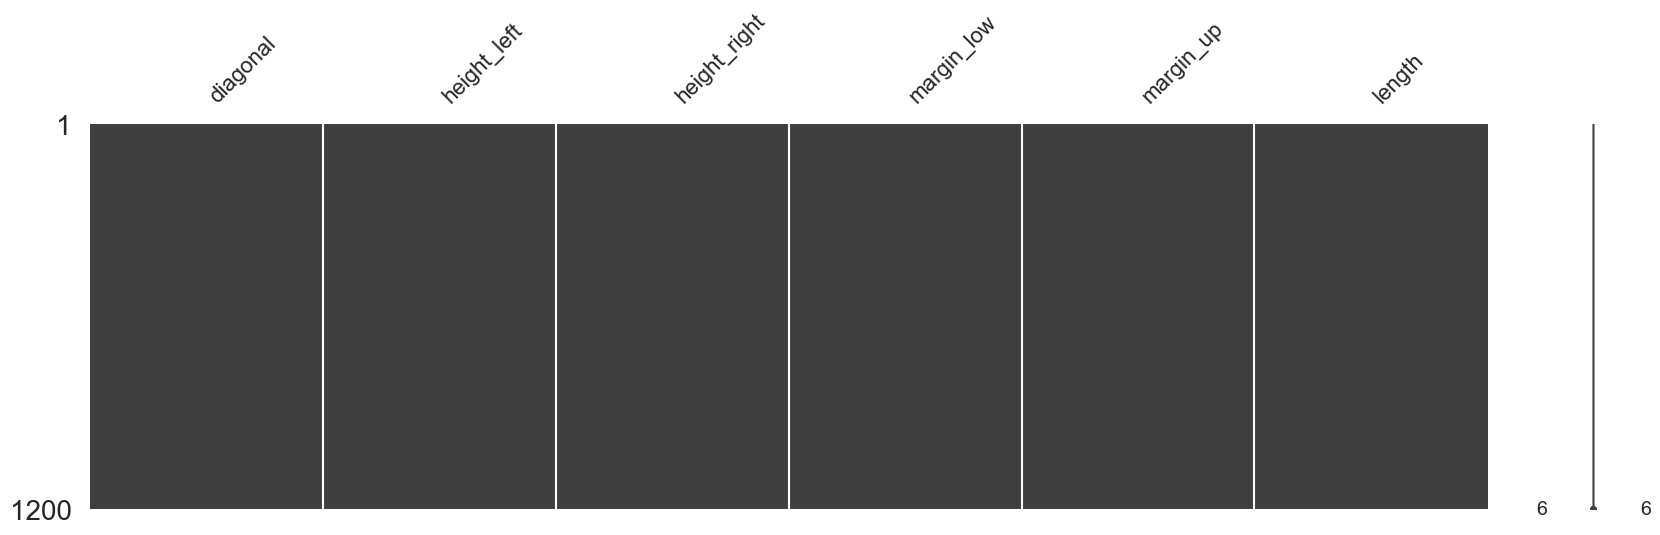

In [242]:
X_prep= pd.DataFrame(preprocessing.fit_transform(X))
X_testprep= pd.DataFrame(preprocessing.fit_transform(X_test))
mno.matrix(X_prep, figsize=(20,5))

* [sommaire](#sommaire)

#  <a class="anchor" id="IV"></a>     IV. Analyse

##   <a class="anchor" id="IV.1"></a>    A. Exploratoire ACP

J'ai d'abord appliqué une analyse des composants principales afin de mieux comprendre le lien et les caractéristiques entre les variables.

###   <a class="anchor" id="IV.1.1"></a>  formules

- Cercle de corrélation
- Projection des individus


In [243]:
# Cercle de corrélation
def correlation_graph(pca, x_y, features) :
    x,y=x_y
    fig, ax = plt.subplots(figsize=(8, 8))

    #Création du graphique
    for i in range(0, pcs.shape[1]):
        ax.arrow(0,0, pcs[x, i], pcs[y, i],head_width=0.03,
                head_length=0.03, color='red', width=0.01, )

        plt.text(pcs[x,i]+0.02, pcs[y,i]+0, features[i], fontsize=14)

    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(scree[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(scree[y],1)))

    plt.title("Cercle des corrélations (F{} et F{}) à {}%".format(x+1, y+1, (round(scree[x]+scree[y], 2))))

    # Le cercle
    plt.gca().add_artist(plt.Circle((0,0), 1, facecolor='none', edgecolor='purple'))

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)



# Projection des individus
def display_factorial_planes( PCA, label1, label2, x, y, echel1, echel2,clusters=None, centroid= None, figsize=(15,15) ):

    ces = (15,15) if figsize is None else figsize
    fig, ax = plt.subplots(1,1, figsize=ces)

    c = None if clusters is None else clusters
    ce= None if centroid is None else plt.scatter(centroids_projected[:,x],centroids_projected[:,y], s=200,
                                                  marker= 's', c='green', alpha=0.3, label='centroids', cmap= 'jet')
    #Nuage de Points
    sns.scatterplot(data=None, x=PCA[label1], y=PCA[label2], hue=c, palette="deep", style=c)

    # Variance
    v1 = str(round(scree[x]))  + " %"
    v2 = str(round(scree[y]))  + " %"
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Bornage            ====================> Même echelle
    x_max = abs(PCA[label1].max()) *1.1
    y_max = abs(PCA[label2].max()) *1.1
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)
    plt.plot([-x_max, x_max], [0,0], color='silver', ls='--', linewidth=1)
    plt.plot( [0,0], [-y_max, y_max], color='grey', ls='--', linewidth=1)
    plt.title(f"Projection des {PCA.shape[0]} individus sur le {x+1}e et {y+1}eme plan factoriel")
    plt.grid(color='white')
    plt.show()

* [sommaire](#sommaire)

###  <a class="anchor" id="IV.1.2"></a>   Ebouli

Table des Variances
  Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            1.070955                  70.0                   70.0
1      Dim2            0.182219                  12.0                   82.0
2      Dim3            0.093047                   6.0                   88.0
3      Dim4            0.085423                   6.0                   93.0
4      Dim5            0.068897                   4.0                   98.0
5      Dim6            0.036340                   2.0                  100.0


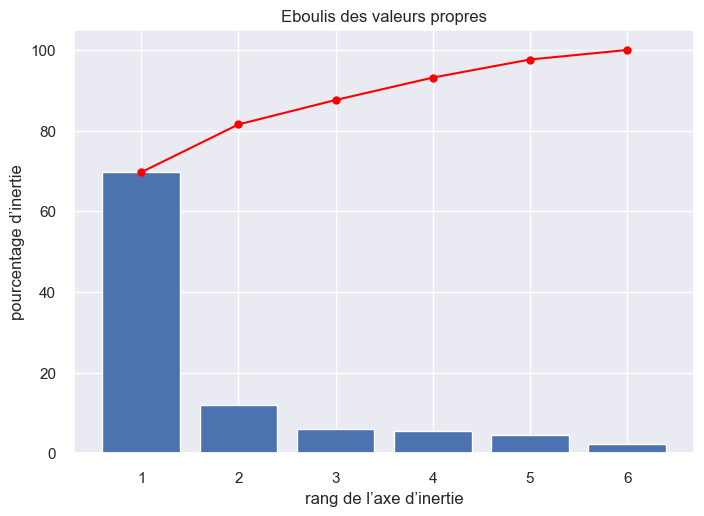

In [244]:
# VARIANCE EXPLIQUE
nbIndiv= len(trainset)
nbVariables=len(df.columns)-1

pca=decomposition.PCA(n_components=6)
pca.fit_transform(X_prep)               # application du PCA sur les données X preprocessing.
X_projected =pca.fit_transform(X_prep)  # Je conserve la projection des variables dans une variables

scree= pca.explained_variance_ratio_*100

plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red', marker='o')
plt.xlabel('rang de l’axe d’inertie')
plt.ylabel('pourcentage d’inertie')
plt.title("Eboulis des valeurs propres")

print("Table des Variances")
print(pd.DataFrame(
    { "Dimension" : ["Dim" + str(x + 1) for x in range(nbVariables)],
        "Variance expliquée" : (nbIndiv-1) / nbIndiv * pca.explained_variance_ ,
        "% variance expliquée" : np.round(scree),
        "% cum. var. expliquée" : np.round(np.cumsum(scree))}))

En regardant l'éboulis des valeurs propres, on remarque que nous nous conservons 70% de l'inertie totale dans la première dimension. En gardant les 2 premières dimensions, nous conservons près de 82% de l'information. Cela confirme une potentielle corrélation entre certaines variables.

* [sommaire](#sommaire)

###  <a class="anchor" id="IV.1.3"></a>   Représentation des variables

In [245]:
features

['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

In [246]:
# REPRESENTATION VARIABLES
pcs= pca.components_         # Vecteurs Propres
pcsvariable = pd.DataFrame(pcs) # Vecteurs Propres
Features= features.copy()
Features.append("margin_low")
pcsvariable.columns = Features
pcsvariable.index= [f"F{i}" for i in range(1, 7)]

Qualité de réprésentation


,ID,COS2_1,COS2_2
5,length,0.700159,0.058043
3,margin_low,0.315907,0.122780
2,height_right,0.024717,0.000569
4,margin_up,0.016644,0.000105
1,height_left,0.013059,0.000110
0,diagonal,0.001362,0.000764


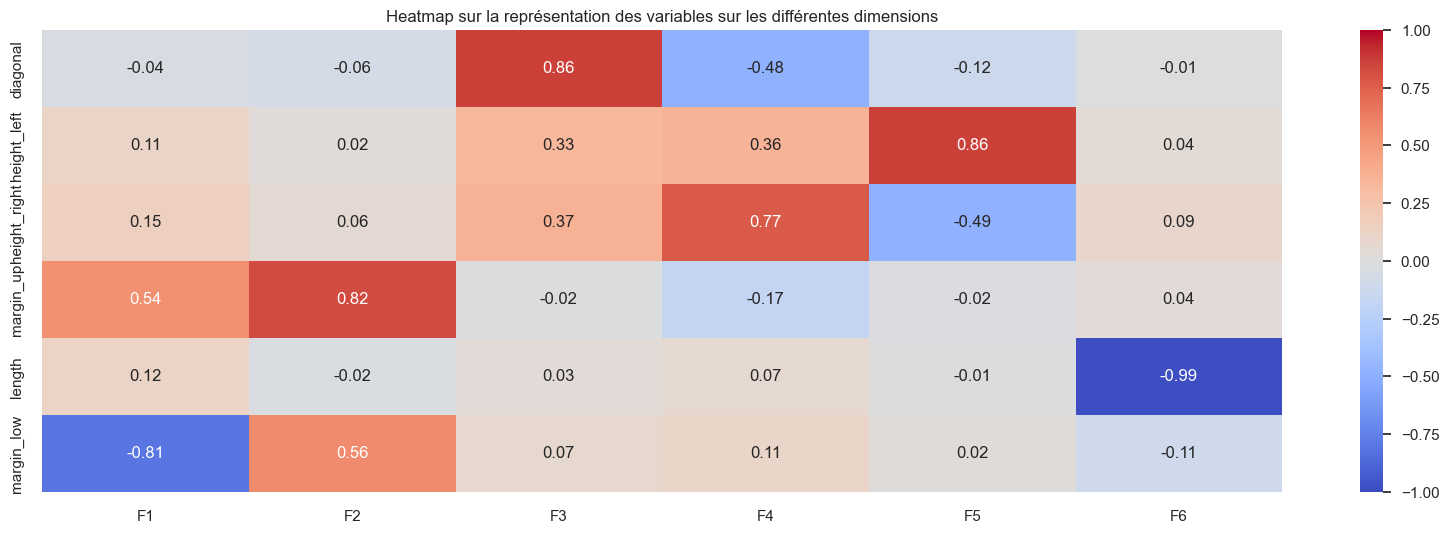

In [247]:
# Représentation par une Heatmap
f, ax_hist = plt.subplots(figsize=(20, 6))
sns.heatmap(pcsvariable.transpose(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title("Heatmap sur la représentation des variables sur les différentes dimensions")

#####
# Corrélations

corvar = np.zeros((nbVariables,nbVariables))
for i in range(nbVariables):   # Mettre les variables en Lignes et les facteurs en colonnes
    corvar[:,i] = pcs[i,:] * np.sqrt(pca.explained_variance_)[i]

# Qualité de représentation des Variables
corvar = corvar**2
print("Qualité de réprésentation")
pd.DataFrame({'ID': trainset.drop(columns='is_genuine').columns, 'COS2_1':corvar[:,0], 'COS2_2':corvar[:,1]}).sort_values(by=["COS2_1"], ascending= [False])

De façon général, au vu de la qualité de représentation, ce sont la variable Length et Margin_low qui sont le mieux représentés. On constate 3 groupes assez distinctes:
* La margin_up et la Margin_low sur les plans Factoriels 1 et 2
* Diagonal, height_right et height_left sur les plans Factoriels 3, 4 et 5.
* et enfin la Length dans le dernier plan.

* [sommaire](#sommaire)

####  <a class="anchor" id="IV.1.3.a"></a>   Axe 1-2

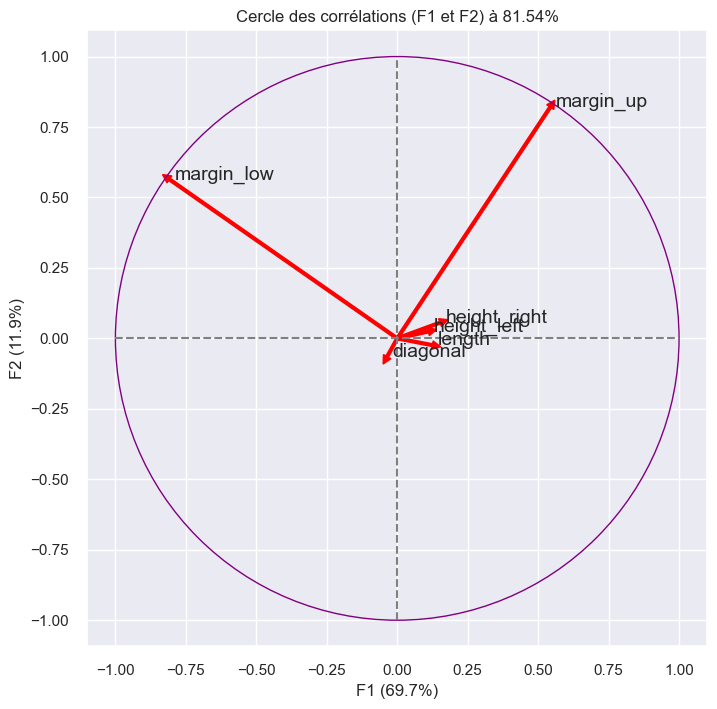

In [248]:
### Repésentation des Variables sur l'axe 1 et 2
correlation_graph(pca, [0,1], Features)

La variable synthétique du 1e axe représente les billets selon leur mesure de la margin_low.
* -1 les mesures sont les plus flaibles.
* 1 les mesures sont les plus élevés.

La variable synthétique du 2e axe représente les billets selon leur mesure de la margin_up.
* -1 les mesures sont les plus flaibles.
* 1 les mesures sont les plus élevés.

On ne retrouve pas de corrélation.

* [sommaire](#sommaire)

####  <a class="anchor" id="IV.1.3.b"></a>   Axe 3-4

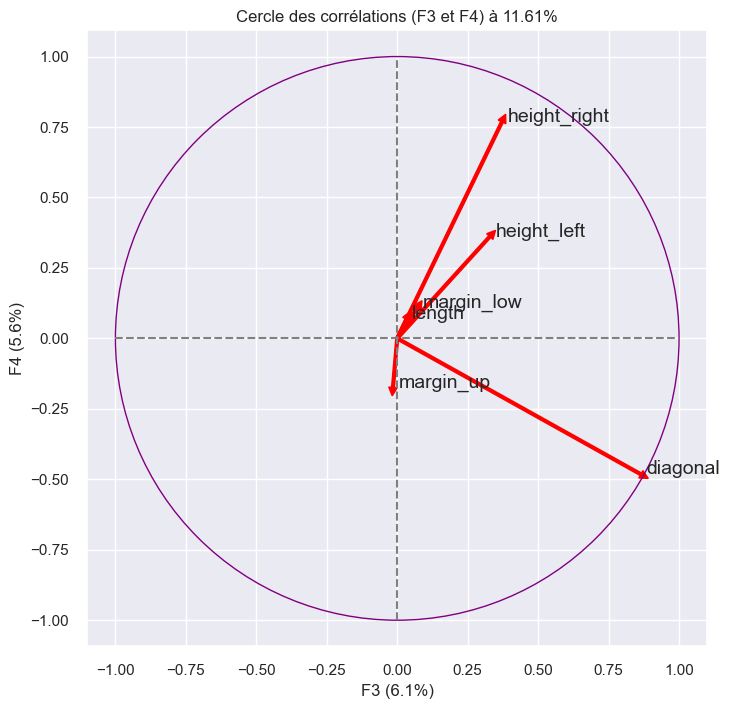

In [249]:
### Représentation des Variables sur l'axe 3 et 4
correlation_graph(pca, [2,3], Features)

La variable synthétique du 3e axe représente les billets selon leur mesure de la diagonal.
*  -1 les mesures sont les plus flaibles.
*  1 les mesures sont les plus élevés.

La variable synthétique du 4e axe représente les billets selon leur mesure de la height_right.
* -1 les mesures sont les plus flaibles.
* 1 les mesures sont les plus élevés.

On retrouve une corrélation entre height_left et right.

* [sommaire](#sommaire)

##    <a class="anchor" id="IV.2"></a>     1. Apprentissage Non supervisé

###  <a class="anchor" id="IV.2.1"></a>   Kmean

####  <a class="anchor" id="IV.2.1.a"></a>    Choix nombre clusters

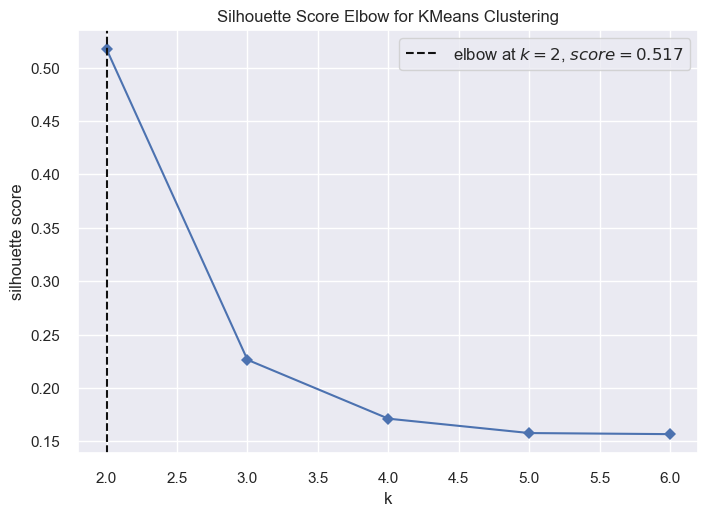

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [250]:
km = KMeans(n_init= "auto",random_state=8)
KElbowVisualizer(km, k=(2,7), metric='silhouette', timings=False).fit(X_prep).show()

Au vu de la silhouette, le nombre de cluster idéal serait de 2.

* [sommaire](#sommaire)

####  <a class="anchor" id="IV.2.1.b"></a>     Application Kmean

In [251]:
# application du K-means avec le nombre de clusters optimal
km=KMeans(n_clusters=2,init='k-means++', max_iter=300, n_init=10, random_state=2)
km.fit_predict(X_prep) # entrainement du jeu de données et prédiction sur l'authenticité
clusters= km.labels_
centroids= km.cluster_centers_

filename1 = 'finalized_modelkm.sav'
pickle.dump(km, open(filename1,'wb'))

CKmeans=pd.DataFrame({'clusters':clusters, "names":trainset.index, "reel_groupe":trainset.is_genuine})
CKmeans["clusters"].value_counts()

1    811
0    389
Name: clusters, dtype: int64

Le kmeans a donc attribué la classe 0 pour 389 billets ce qui équivaut au groupe de faux billets et 811 billets dans la classe 1 ce qui équivaut au groupe des vrais billets.

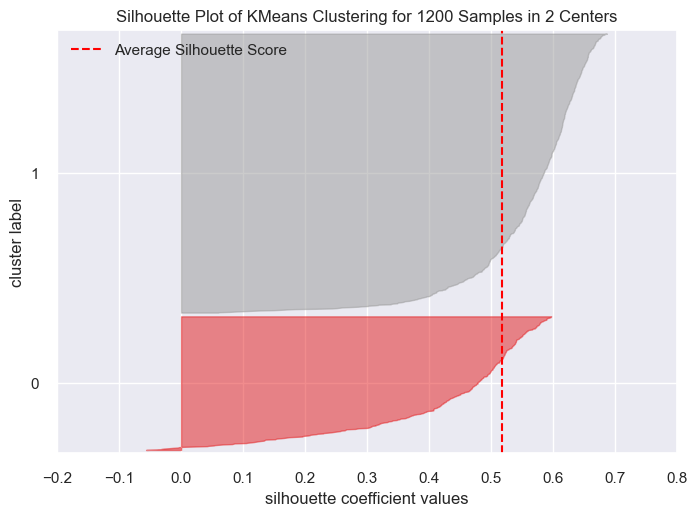

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1200 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [252]:
SilhouetteVisualizer(km, color='yellowbrick').fit(X_prep).show()

SILHOUETTE montre la densité et la séparation entre chaque cluster
* +1 grande distance séparant clusters
* -1 assigne mauvais cluster
* ligne rouge correspond au score moyen sur tous les clusters
  * => Si sous la lignes alors déséquilibrer.

Ici les 2 classes ont une belle silhouette. Il y a quelques outliers détectés au sein de la classe 0.


* [sommaire](#sommaire)

####  <a class="anchor" id="IV.2.1.c"></a>     centroides

In [253]:
pd.DataFrame(centroids, columns=[df.drop(columns='is_genuine', axis=1).columns])

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.890308,104.196427,104.146504,5.243977,3.344987,111.592674
1,171.980814,103.950111,103.810875,4.123338,3.056979,113.191406


La classe des faux billets a en moyenne une diagonal moins importante que les vrais billets autour de 171,89mm. Elles ont également une hauteur à gauche et à droite plus élevée que les vrais billets autour de 104,19mm et 104,14mm. La partie gauche à tendance à être dans tous les cas plus haute que sur le côté droite. Concernant la marge sur le bas du faux billet, elle est beaucoup plus élevée que sur un véritable billet autour de 5,24 mm contre seulement 4,12mm en moyenne pour les vrais billets. On rencontre aussi une différence plus légère au niveau de la marge du dessus, avec une marge plus élevée également pour les faux billets autour de 3,34mm. Enfin, au niveau de la longueur, on remarque également une différence très prononcée entre les faux et les vrais billets. Les faux billets ont tendance à être plus petit que les vrais billets autour de 111,59mm.

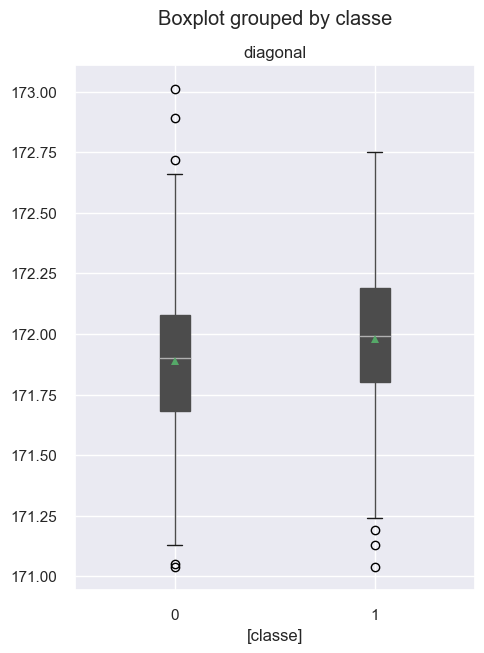

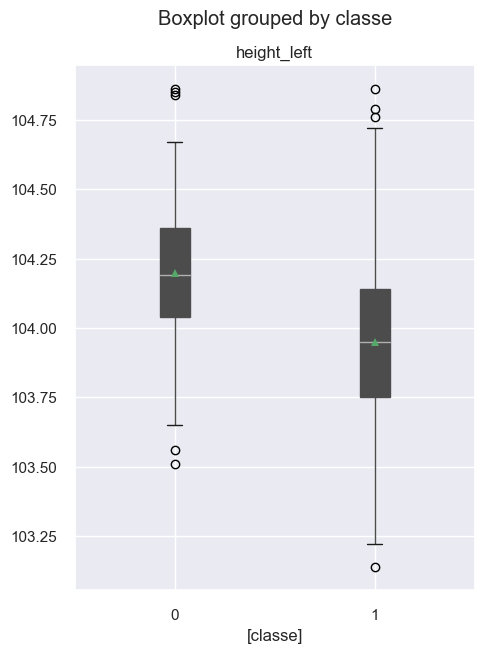

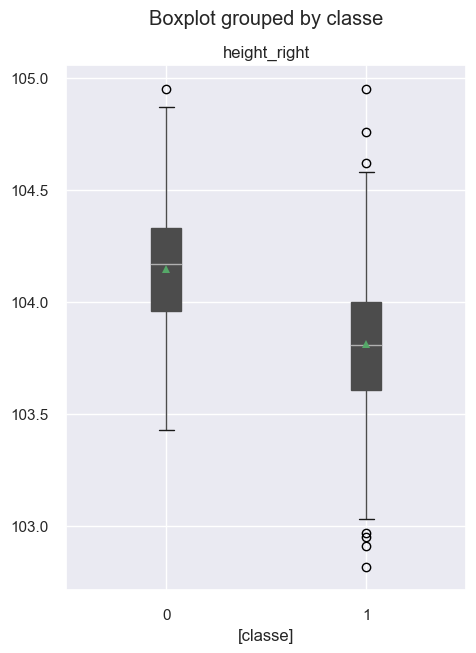

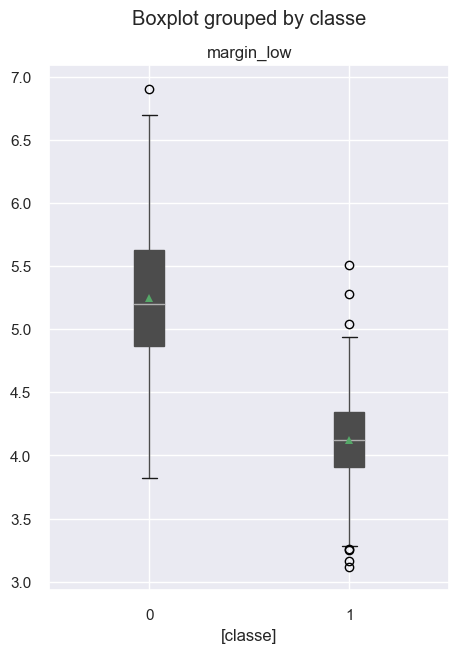

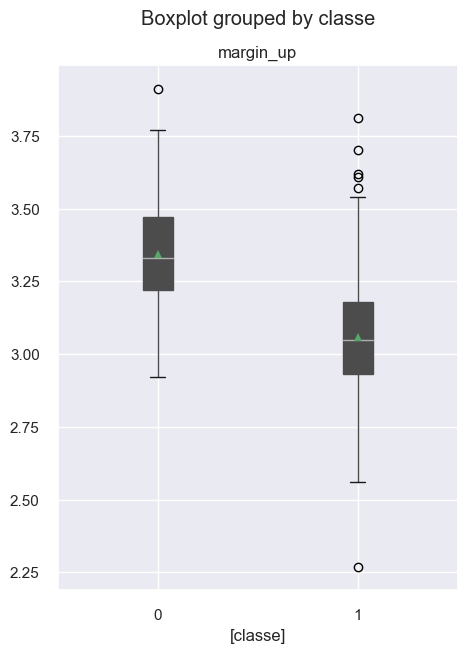

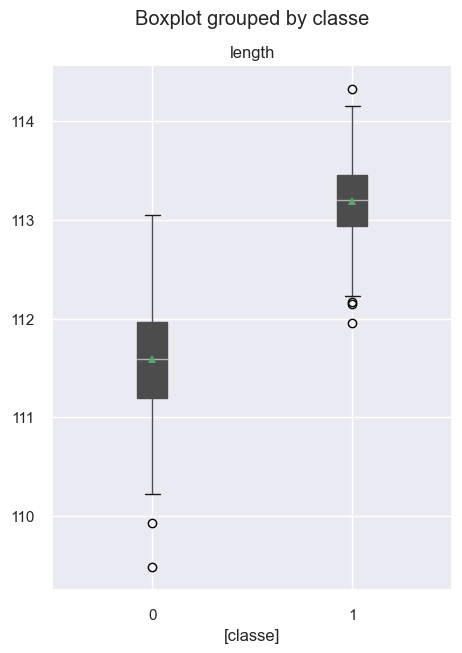

In [254]:
CKmeans = trainset.assign(classe = clusters)
for i in X.columns:
  CKmeans[[i,"classe"]].boxplot(by="classe", figsize=(5,7), patch_artist=True,showmeans=True)
  plt.show()

Malgré le fait que les mesures de diagonales des faux billets sont en moyenne plus petites que celles des vrais billets, on remarque que sa dispersion quant à elle reste assez élevé et de nombreux faux billets ont également des mesures au-dessus de la moyenne des vrais billets rendant la dispersion des faux billet assez similaire à celle des vrais billets.

On retrouve cette même analyse avec une dispersion un peu plus distinguée pour les mesures de hauteurs à droites et à gauche et la hauteur de marge en haut.

Et enfin on remarque que la dispersion des mesures de la marge en bas et de longueurs sont très différentes entre les vrais et les faux billets. Ce serait donc bien ces 2 mesures qui seraient déterminant pour prédire l'authenticité du billet.

* [sommaire](#sommaire)

###  <a class="anchor" id="IV.2.2"></a>     Evaluation / Associations

#### Evaluation et erreur sur le train set

In [255]:
print(confusion_matrix(Y, clusters).T)

[[387   2]
 [ 16 795]]


c0v = classe 0 vrai, COVT= Classe 0 vrai total, C1P= classe 1 prédit, C0PT = Classe0 prédit Total




---



---


*  ......................**C0V** ......./.....**C1V**................................................

* **C0P**: Vrai Negatif 387    //    Faux Négatif 2 =====> 389 C0PT
* **C1P**: Faux Positif 16      ////    Vrai Positif 795 =====> 811 C1PT
* Total..... 403 COVT.............797 C1VT......................................


on remarque que sur les 403 faux billets initiales, 16 ont mal été classé dans le groupe des vrais billets. Et sur les 797 vrais billets initiales, 2 ont été classé en faux billets.

In [256]:
print(classification_report(Y, clusters))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       403
           1       0.98      1.00      0.99       797

    accuracy                           0.98      1200
   macro avg       0.99      0.98      0.98      1200
weighted avg       0.99      0.98      0.98      1200



* **Precision** = Vrai Négatif prédit / C0PT
  * Plus il est élevé, plus le modèle minimise le nombre de faux Négatif. => la majorité des Vrai négatifs sont bien prédit.
* **Recall** = Vrai Négatif prédit / C0VT
    * Plus il est élevé, plus le modèle maximise le nombre de Vrai Négatif.  => il ne ratera pas de faux billets
* **F1 Score** = 2 * ((recall*precision) /(recall + precision))
   * moyenne harmonique des 2 scores, plus elle est élevée plus le modèle sera performant.

Comme vu plus haut, ce qui nous intéresse le plus est la sensibilité du modèle. On veut réduire au maximum le taux de Faux positif donc de Faux billets prédits en Vrai billets.
Il sera donc intéressant de se baser sur les score de la classe 0 qui est notre classe qu'on souhaite prédire le plus juste possible.

* Precision classe 0 = 387 / 389 = 99% on arrive à une précision de 99%
* Recall classe 0 = 387 / 403 = 96% le score est moins élevé mais reste largement suffisant.
* F1-Score classe 0 = 2* ((96%*99%)/(96%+99%)) = 98% La moyenne Harmonique y est très élevée.


Le taux de reconnaissance en test est de 98%.

In [257]:
trainset[(Y != clusters)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1073,False,172.13,103.67,103.82,4.27,3.22,112.15
1024,False,171.52,104.05,104.31,4.24,3.70,112.60
728,True,171.94,104.11,104.16,4.08,3.35,111.76
1190,False,171.45,104.21,104.18,4.55,3.52,113.21
1103,False,171.88,104.05,103.75,4.41,3.21,112.52
1078,False,172.21,104.40,104.28,5.28,3.42,112.99
1081,False,171.82,103.90,103.67,4.79,3.36,112.43
1025,False,172.17,104.20,104.13,3.86,3.38,112.44
1407,False,172.02,103.99,104.28,4.22,2.98,112.42
1122,False,172.09,104.15,104.17,4.15,3.40,113.85


In [258]:
trainset[(Y != clusters)].groupby("is_genuine").mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.946875,104.10125,104.08375,4.4375,3.40625,112.6975
True,171.805000,103.96000,103.96000,4.3350,3.32500,111.9700


En observant le profil des billets mal classés, on remarque que la moyenne des mesures entre les 2 groupes est assez proche pour chaque variable, rendant la distinction assez difficile. Seule la margin_up et la length ont des moyennes plus éloignées.
On remarque d'ailleurs que la moyenne de la length est plus petite pour les 3 vrais billets alors que les centroïdes indiquent normalement une length plus importante pour les vrais billets. Idem pour la margin_low des faux billets.

* [sommaire](#sommaire)

#### Evaluation Prédictions sur le test set

In [259]:
Y_pred=km.predict(X_testprep)
print(confusion_matrix(Y_test, Y_pred).T)

[[ 94   0]
 [  3 203]]



*  ......................**C0V** ......./.....**C1V**................................................

* **C0P**: Vrai Negatif 94    //    Faux Négatif 0 =====> 94 C0PT
* **C1P**: Faux Positif 3      ////    Vrai Positif 203 =====> 206 C1PT
* Total..... 97 COVT.............203 C1VT........................................


on remarque que sur les 97 faux billets initiales, 3 ont mal été classé dans le groupe des vrais billets. Et les 203 vrais billets ont tous été bien classé dans le groupe des vrais billets.

In [260]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        97
           1       0.99      1.00      0.99       203

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.99       300
weighted avg       0.99      0.99      0.99       300



* Precision classe 0 = 94 / 94 = 100% on arrive à une précision de 100%
* Recall classe 0 = 94 / 97 = 97% le score est aussi moins élevé mais plus élevé que le score sur le trainset.
* F1-Score classe 0 = 2* ((97%*100%)/(97%+100%)) = 98% La moyenne Harmonique y est aussi très élevée.

Le taux de reconnaissance en test est de 99%.

In [261]:
testset[(Y_test != Y_pred)]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1083,False,171.85,103.60,103.82,4.60,3.21,112.50
1223,False,172.24,104.31,104.66,4.20,3.61,112.37
1087,False,171.91,104.28,103.86,5.48,3.37,113.13


In [262]:
testset[(Y_test != Y_pred)].mean()

is_genuine        0.000000
diagonal        172.000000
height_left     104.063333
height_right    104.113333
margin_low        4.760000
margin_up         3.396667
length          112.666667
dtype: float64

On remarque que la mesures de certaines variables sont proches des centroides de la classe 0 tel que la mesure du margin_up, margin_low, height_right.

* [sommaire](#sommaire)

##   <a class="anchor" id="IV.3"></a>     2. Apprentissage Supervisé

###   <a class="anchor" id="IV.3.1"></a>     Création Pipelines des Modèles

In [263]:
LogisticR_pipe = Pipeline([
                    ('preprocessing', preprocessing),
                    ('LR',LogisticRegression() )],verbose=False)

In [264]:
knn_pipe = Pipeline([
                     ('preprocessing', preprocessing),
                     ('knn', KNN())
                     ],verbose=False)

In [265]:
ridge_pipe = Pipeline([
                      ('preprocessing', preprocessing),
                      ('ridge', RidgeClassifier())])

In [266]:
rf_pipe = Pipeline([
                      ('preprocessing', preprocessing),
                      ('rf', RandomForest(random_state=777))])

J'ai créé une Pipeline qui permet d'appliquer à la fois le preprocessing sur mon dataset et l'apprentissage supervisé à partir d'un modèle de classification pour classifier les vrais et les faux billets.  J'ai souhaité tester 4 modèles de Classification afin de choisir le meilleur modèle de prédiction.
* **Regression Logistique**
  * la méthode la plus simple de classification qui se base sur une régression linéaire avec une fonction logistique comme lien.
* **KNeighborsClassifier**
  * les K données les plus proches de la donnée de prédiction
* **RidgeClassifier**
  * Régressions sur les features les plus importantes
* **RandomForest**
  * la combinaisons des résultats d'arbres de décisions suivant les features afin d'obtenir le meilleur résultat.

* [sommaire](#sommaire)

###  <a class="anchor" id="IV.3.2"></a>  CROSS VALIDATION pour Evaluer les Pipelines

####  <a class="anchor" id="IV.3.2.a"></a>  Création CrossValidation

In [267]:
cross_val_folds = KFold(n_splits= 5, shuffle=True,random_state=1)

Afin de pouvoir tester la performance de mon modèle j'ai souhaité appliquer une cross Validation en découpant mon train set en 5 groupes= 4 groupes pour entrainer et un 5 e groupe pour valider la performance. Je pourrais donc tester 5 groupes différents et choisir la meilleure découpe.
j'ai choisi la méthode du KFold.

####  <a class="anchor" id="IV.3.2.b"></a>  Evaluation des modèles

In [268]:
cv_score= cross_val_score(LogisticR_pipe, X,Y, cv= cross_val_folds, scoring='balanced_accuracy' )
print(cv_score)
cv_score.mean(), cv_score.std()


[0.98765432 0.99342105 0.9905653  0.9839455  0.97666667]


(0.9864505677300295, 0.005813221879326132)

In [269]:
cv_score= cross_val_score(knn_pipe, X,Y, cv= cross_val_folds, scoring='balanced_accuracy' )
print(cv_score)
cv_score.mean(), cv_score.std()

[0.98765432 0.98379332 0.9905653  0.98701299 0.98      ]


(0.9858051857579664, 0.003613433295778699)

In [270]:
cv_score= cross_val_score(ridge_pipe, X,Y, cv= cross_val_folds, scoring='balanced_accuracy' )
print(cv_score)
cv_score.mean(), cv_score.std()


[0.98148148 0.98684211 0.98423618 0.98051948 0.98      ]


(0.9826158498707812, 0.002569472233269822)

In [271]:
cv_score= cross_val_score(rf_pipe, X,Y, cv= cross_val_folds, scoring='balanced_accuracy' )
print(cv_score)
cv_score.mean(), cv_score.std()


[0.98765432 0.99342105 0.9905653  0.98701299 0.98777778]


(0.989286286884767, 0.0024016226537696794)

Afin de pouvoir évaluer mon modèle, j'ai utilisé la fonction cross_val_score où j'ai :
* passé ma Pipeline
* Choisi mes Features et ma target
* Choisi la méthode de Cross Validation
* Choisi la méthode de scoring à balanced_acccuracy qui une autre méthode de scoring sur la base de la moyenne pondérée du score recall sur les vrais et les faux billets. (0.5*Recall True) + (0.5*Recall False)

La RF a le meilleur score, suivi de la régression logistique puis du KNN et enfin par le ridge classifier.

* [sommaire](#sommaire)

###  <a class="anchor" id="IV.3.3"></a>  Optimiser avec GridSearch

Avec la Cross Validation, On va tester pour chaque modèle,différent hyperparamètres afin d'optimiser et améliorer le score des modèles.

####  <a class="anchor" id="IV.3.3.a"></a>  Création de la GridSearch

#####  <a class="anchor" id="IV.3.3.a.i"></a>  Regression logistique

In [272]:
print(LogisticRegression().get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [273]:
LR = {}
LR['pipeline'] = LogisticR_pipe

## grille pour la pipeline LR avec les différentes valeurs à tester pour chaque hyper paramètre.
LR['hyperparametres']= {}
LR['hyperparametres']['LR__C']= [10, 100]
LR['hyperparametres']['LR__penalty']= [None,"l2"]
LR['hyperparametres']['LR__solver']= ['newton-cg',"saga"]

## GridSearch pour la pipeline
LR['gridsearch'] =GridSearchCV(estimator=LR['pipeline'],
                                param_grid= LR['hyperparametres'],
                                scoring='balanced_accuracy',
                                cv =cross_val_folds, error_score='raise')

#####  <a class="anchor" id="IV.3.3.a.ii"></a>  KNN

In [274]:
print(KNN().get_params())

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [275]:
knn = {}
knn['pipeline'] =knn_pipe

## grille pour la pipeline KNN
knn['hyperparametres']= {}
knn['hyperparametres']['knn__n_neighbors']= [1,3,5,7,9,13,7,21,27,29]
knn['hyperparametres']['knn__weights']= ['uniform','distance']

## GridSearch pour la pipeline
knn['gridsearch'] =GridSearchCV(estimator=knn['pipeline'],
                                param_grid= knn['hyperparametres'],
                                scoring='balanced_accuracy',
                                cv =cross_val_folds)

#####  <a class="anchor" id="IV.3.3.a.iii"></a>  Ridge Classifier

In [276]:
print(RidgeClassifier().get_params())

{'alpha': 1.0, 'class_weight': None, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


In [277]:
ridge = {}
ridge['pipeline'] =ridge_pipe

## grille pour la pipeline ridge
ridge['hyperparametres']= {}
ridge['hyperparametres']['ridge__alpha']=[0.1, 0.5, 0.8, 1, 1.3, 1.5, 1.9]

## GridSearch pour la pipeline
ridge['gridsearch'] =GridSearchCV(estimator=ridge['pipeline'],
                                param_grid= ridge['hyperparametres'],
                                scoring='balanced_accuracy',
                                cv =cross_val_folds)

#####  <a class="anchor" id="IV.3.3.a.iv"></a>  Random Forest

In [278]:
print(RandomForest().get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [279]:
rf = {}
rf['pipeline'] =rf_pipe

## grille pour la pipeline rf
rf['hyperparametres']= {}
rf['hyperparametres']['rf__n_estimators']= [33,150 ]
rf['hyperparametres']['rf__max_features']= [0.1, 0.66]
rf['hyperparametres']['rf__max_depth']= [None, 2]
rf['hyperparametres']['rf__min_samples_split']= [2, 10]




## GridSearch pour la pipeline
rf['gridsearch'] =GridSearchCV(estimator=rf['pipeline'],
                                param_grid= rf['hyperparametres'],
                                scoring='balanced_accuracy',
                                cv =cross_val_folds)

* [sommaire](#sommaire)

####  <a class="anchor" id="IV.3.3.b"></a>  Trouver les meilleurs hyperparamètres

In [280]:
LR['gridsearch'].fit(X,Y) # entrainer la grid Search
print(LR['gridsearch'].best_params_) # ressort les meilleurs hyper paramètres
print(LR['gridsearch'].best_score_) # ressort le meilleur score.

{'LR__C': 10, 'LR__penalty': 'l2', 'LR__solver': 'newton-cg'}
0.9863802806740575


In [281]:
knn['gridsearch'].fit(X,Y)
print(knn['gridsearch'].best_params_)
print(knn['gridsearch'].best_score_)

{'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
0.9864149418555274


In [282]:
ridge['gridsearch'].fit(X,Y)
print(ridge['gridsearch'].best_params_)
print(ridge['gridsearch'].best_score_)

{'ridge__alpha': 0.1}
0.9826158498707812


In [283]:
rf['gridsearch'].fit(X,Y)
print(rf['gridsearch'].best_params_)
print(rf['gridsearch'].best_score_)

{'rf__max_depth': None, 'rf__max_features': 0.66, 'rf__min_samples_split': 2, 'rf__n_estimators': 33}
0.9887344586256702


Pour chaque modèle, on a pu déterminer les hyper paramètres optimales pour optimiser nos modèles.

* [sommaire](#sommaire)

###   <a class="anchor" id="IV.3.4"></a>  Pipeline Finale

Après avoir optimiser nos modèles, nous allons pouvoir tester notre pipeline avec les meilleurs hyper paramètres.

####  <a class="anchor" id="IV.3.4.a"></a>  Pipeline Final sur le Modèle avec le meilleur score

#####  <a class="anchor" id="IV.3.4.a.i"></a>  Création pipeline avec les meilleurs hyper paramètres

In [284]:
pipeline_final = make_pipeline(preprocessing,
                               RandomForest(
                                  max_depth= None,
                                  max_features= 0.1,
                                  min_samples_split= 10,
                                  n_estimators= 33)
                               )

In [285]:
# Création de fonction pour fournir la prédiction
def predictionML(table):
  table= table.reset_index(drop=True)
  predict= pipeline_final.predict(table) # prédiction sur nouveau jeu de donnée
  decod=Target_encoder.inverse_transform(predict)  # décodage
  proba= pd.DataFrame(pipeline_final.predict_proba(table)) # Calcul de la proba d'appartenir au groupe 1 ou 0
  table=table.assign(is_genuine= decod)
  table= table.assign(probaFaux= proba[0])
  table= table.assign(probaVrai= proba[1])
  return table

def PredY(table):
  table= table.reset_index(drop=True)
  predict= pipeline_final.predict(table) # prédiction sur nouveau jeu de donnée
  Y_pred=Target_encoder.inverse_transform(predict)  # décodage
  return Y_pred


* [sommaire](#sommaire)

#####  <a class="anchor" id="IV.3.4.a.ii"></a>  Evaluation
interpréter coef

In [286]:
pipeline_final.fit(X,Y)
Y_pred = PredY(X_test)
predict= predictionML(X_test)
predict

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,probaFaux,probaVrai
0,172.58,104.17,103.13,4.64,3.17,113.05,True,0.119276,0.880724
1,172.47,104.07,104.02,4.04,3.25,113.45,True,0.097009,0.902991
2,171.47,104.15,103.82,4.63,3.37,112.07,False,0.831019,0.168981
3,172.02,103.58,103.80,3.95,3.46,112.40,True,0.358256,0.641744
4,171.95,104.39,104.31,5.98,3.23,111.33,False,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...
295,171.26,103.59,103.80,4.11,3.25,113.03,True,0.042857,0.957143
296,171.63,103.87,104.66,NaN,3.27,112.68,False,0.568684,0.431316
297,171.79,103.69,103.68,3.65,2.77,112.78,True,0.000000,1.000000
298,172.19,104.63,104.44,5.27,3.37,110.97,False,0.981352,0.018648


J'ai appliqué le modèle de prédiction sur le testset que j'avais mis de côté afin de pouvoir évaluer la qualité du modèle.
On retrouve donc une colonne "is_genuine qui prédit suivant les mesures géométriques si le billet est vrai ou faux avec sa probabilité d'être fausse.

In [287]:
print(classification_report(Target_encoder.inverse_transform(Y_test), Y_pred))
Y_testDecode = Target_encoder.inverse_transform(Y_test)

              precision    recall  f1-score   support

       False       0.99      0.99      0.99        97
        True       1.00      1.00      1.00       203

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



* **Precision**
  * Plus il est élevé, plus le modèle minimise le nombre de faux Négatif. => la majorité des Vrai négatifs sont bien prédit.
  * on arrive à une précision de 99%. Elle est moins élevé que celle du Kmeans.
* **Recall**
    * Plus il est élevé, plus le modèle maximise le nombre de Vrai Négatif.  => il ne ratera pas de faux billets.
    * On arrive à une sensibilité à 98% qui est bien meilleur que celle du Kmeans de 97%.
* **F1 Score**
   * moyenne harmonique des 2 scores. plus elle est élevée plus le modèle sera performant.
   * La moyenne Harmonique y est très élevée 98%.

Le taux de reconnaissance en test est de 99%.

* [sommaire](#sommaire)

#####  <a class="anchor" id="IV.3.4.a.iv"></a>  Erreur

In [288]:
print(confusion_matrix(Y_test, Y_pred).T)

[[ 96   1]
 [  1 202]]


*  ......................**C0V** ......./.....**C1V**................................................

* **C0P**: Vrai Negatif 95    //    Faux Négatif 1 =====> 96 C0PT
* **C1P**: Faux Positif 2      ////    Vrai Positif 202 =====> 204 C1PT
* Total..... 97 COVT.............203 C1VT......................................


on remarque que sur les 97 faux billets initiales, 2 a mal été classé dans le groupe des vrais billets. Et sur les 203 vrais billets initiales, 1 ont été classé en faux billets.

In [289]:
predict[(Y_test != Y_pred)]

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,probaFaux,probaVrai
46,171.85,103.60,103.82,4.6,3.21,112.50,True,0.225606,0.774394
296,171.63,103.87,104.66,NaN,3.27,112.68,False,0.568684,0.431316


In [290]:
testset[(Y_test != Y_pred)].groupby("is_genuine").mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.85,103.60,103.82,4.6,3.21,112.50
True,171.63,103.87,104.66,NaN,3.27,112.68


En observant le profil des billets mal classés, on remarque que la moyenne des mesures entre les 2 groupes est assez proche pour chaque variable, rendant la distinction assez difficile, notamment sur la length et la margin_low qui sont des mesures décisifs. La probabilité n'etait pas près élevée pour ces billets mal classés.

* [sommaire](#sommaire)

#####  <a class="anchor" id="IV.3.4.a.iii"></a>  Learning curve

Text(0.5, 1.0, "Courbe d'apprentissage de la Régression linéaire")

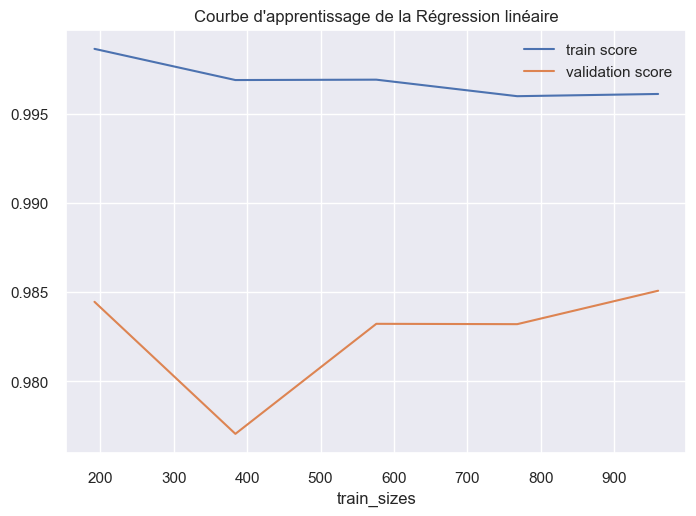

In [291]:
N, train_score, val_score = learning_curve(pipeline_final, X, Y, scoring='balanced_accuracy', train_sizes=np.linspace(0.2, 1.0, 5), cv=5)
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.xlabel('train_sizes')
plt.legend()
plt.title("Courbe d'apprentissage de la Régression linéaire")

Vérifier la courbe d'apprentissage permet de détecter si le modèle est en overfitting et voir si le trainset est de taille suffisant. Ici on remarque qu'un training set de 800 billets étaient suffisant pour obtenir un bon validation score.
Nous ne sommes pas dans un cas d'overfitting ou underfitting car la courbe d'apprentissage entre le train set et le testset ne sont pas en sur ou sous apprentissage.

* [sommaire](#sommaire)

####  <a class="anchor" id="IV.3.4.b"></a>  Pipeline Final sur Modèle Demandé

#####  <a class="anchor" id="IV.3.4.b.i"></a>  Création pipeline avec les meilleurs hyper paramètres

In [292]:
pipeline_final = make_pipeline(preprocessing,
                               LogisticRegression(C =10,
                                penalty="l2",
                                solver= "newton-cg")
                               )

* [sommaire](#sommaire)

#####  <a class="anchor" id="IV.3.4.b.ii"></a>  Evaluation
interpréter coef

In [293]:
pipeline_final.fit(X,Y)
Y_pred = PredY(X_test)
predict =predictionML(X_test)
predict

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,probaFaux,probaVrai
0,172.58,104.17,103.13,4.64,3.17,113.05,True,0.007189,0.992811
1,172.47,104.07,104.02,4.04,3.25,113.45,True,0.001003,0.998997
2,171.47,104.15,103.82,4.63,3.37,112.07,False,0.970585,0.029415
3,172.02,103.58,103.80,3.95,3.46,112.40,True,0.143516,0.856484
4,171.95,104.39,104.31,5.98,3.23,111.33,False,0.999999,0.000001
...,...,...,...,...,...,...,...,...,...
295,171.26,103.59,103.80,4.11,3.25,113.03,True,0.005119,0.994881
296,171.63,103.87,104.66,NaN,3.27,112.68,False,0.826512,0.173488
297,171.79,103.69,103.68,3.65,2.77,112.78,True,0.000040,0.999960
298,172.19,104.63,104.44,5.27,3.37,110.97,False,0.999999,0.000001


J'ai également appliqué le modèle de régression logistique de prédiction sur le testset que j'avais mis de côté afin de pouvoir évaluer la qualité du modèle. On retrouve donc une colonne "is_genuine qui prédit suivant les mesures géométriques si le billet est vrai ou faux avec sa probabilité d'être fausse.

In [294]:
filename = 'finalized_model.sav'
pickle.dump(pipeline_final, open(filename,'wb'))

In [295]:
print(classification_report(Target_encoder.inverse_transform(Y_test), Y_pred))
Y_testDecode = Target_encoder.inverse_transform(Y_test)

              precision    recall  f1-score   support

       False       0.99      0.99      0.99        97
        True       1.00      1.00      1.00       203

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



**Precision**
* Plus il est élevé, plus le modèle minimise le nombre de faux Négatif. => la majorité des Vrai négatifs sont bien prédit.
* on arrive à une précision de 99%. Elle est aussi élevée que celle du random Forest.

**Recall**
* Plus il est élevé, plus le modèle maximise le nombre de Vrai Négatif. => il ne ratera pas de faux billets.
* On arrive à une sensibilité à 99% qui est meilleure à celle de la RF.


**F1 Score**
* moyenne harmonique des 2 scores. plus elle est élevée plus le modèle sera performant.
* La moyenne Harmonique y est très élevée 99%. La plus élevée de tous les modèles.

Le taux de reconnaissance en test est de 99%.

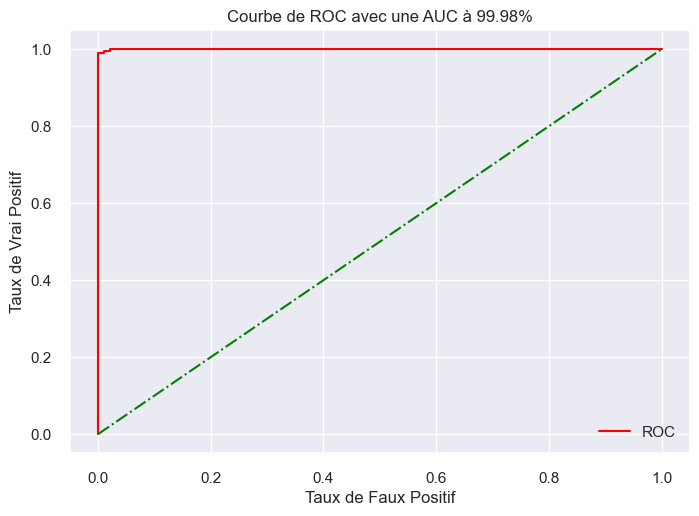

In [296]:
def Courbe_roc(fp, tp):
    plt.plot(fp, tp, c='red', label='ROC')  #tper =True positive, Fper= Flase positive
    plt.plot([0, 1], [0, 1], c='green', ls='-.') # trace la ligne
    AUC= round((roc_auc_score(Y_test, pipeline_final.predict_proba(X_test)[:,1]))*100, 2) # Calcul de AUC
    plt.xlabel('Taux de Faux Positif')
    plt.ylabel('Taux de Vrai Positif')
    plt.title(f'Courbe de ROC avec une AUC à {AUC}%')
    plt.legend()
    plt.show()


fp, tp, thresholds = roc_curve(Y_test, pipeline_final.predict_proba(X_test)[:,1]) # extraire l'inforamtion du taux de faux positif, vrai positif et le seuil
Courbe_roc(fp, tp)

L'AUC (Aera under ROC) qui mesure la qualité du classement, indique un taux de 0.99 ce qui est très proche de 1 et représente donc un très bon score.

In [297]:
proba1= pipeline_final.predict_proba(X_prep)[:,1]   # Récup de la proba.
log_likelihood = np.sum(Y*np.log(proba1)+(1.0-Y)*np.log(1.0-proba1)) # Calcul de l'estimation du maximum de vraissemblance
print(log_likelihood)

-37.60155209235744


In [298]:
XTrainBis = sm.tools.add_constant(X_prep)  # Rajout d'une variable constante pour notre regression.
XTrainBis= XTrainBis.drop(columns=["diagonal", "height_left"], axis=1)
lr = Logit(endog=Y,exog=XTrainBis)
res = lr.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.031056
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           MLE   Df Model:                            4
Date:                Tue, 20 Jun 2023   Pseudo R-squ.:                  0.9513
Time:                        22:19:02   Log-Likelihood:                -37.267
converged:                       True   LL-Null:                       -765.88
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -194.3825    150.546     -1.291      0.197    -489.447     100.682
height_right    -3.682

En supprimant les variables Diagonal et Height_left, on améliore légèrement l'estimateur du maximum de vraisemblance en passant de -37.60 à -37.26

* [sommaire](#sommaire)

#####  <a class="anchor" id="IV.3.4.b.iv"></a>   Erreur

In [299]:
print(confusion_matrix(Y_test, Y_pred).T)

[[ 96   1]
 [  1 202]]


*  ......................**C0V** ......./.....**C1V**................................................

* **C0P**: Vrai Negatif 96    //    Faux Négatif 1 =====> 97 C0PT
* **C1P**: Faux Positif 1      ////    Vrai Positif 202 =====> 203 C1PT
* Total..... 97 COVT.............203 C1VT......................................


on remarque que sur les 97 faux billets initiales, 1 a mal été classé dans le groupe des vrais billets. Et sur les 203 vrais billets initiales, 1 a été classé en faux billets.

In [300]:
predict[(Y_test != Y_pred)]

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,probaFaux,probaVrai
46,171.85,103.60,103.82,4.6,3.21,112.50,True,0.274097,0.725903
296,171.63,103.87,104.66,NaN,3.27,112.68,False,0.826512,0.173488


In [301]:
#predict[(predict["probaFaux"]<=0.9)&(predict["probaFaux"]>=0.2)]

In [302]:
testset[(Y_test != Y_pred)].groupby("is_genuine").mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.85,103.60,103.82,4.6,3.21,112.50
True,171.63,103.87,104.66,NaN,3.27,112.68


En observant le profil des billets mal classés, on remarque que la moyenne des mesures entre les 2 groupes est assez proche pour chaque variable, rendant la distinction assez difficile, notamment sur la length et la margin_low qui sont des mesures décisifs.La probabilité y est moins élevée pour ces billets mal classés.

* [sommaire](#sommaire)

#####  <a class="anchor" id="IV.3.4.b.iii"></a>  Learning curve

Text(0.5, 1.0, "Courbe d'apprentissage de la Régression linéaire")

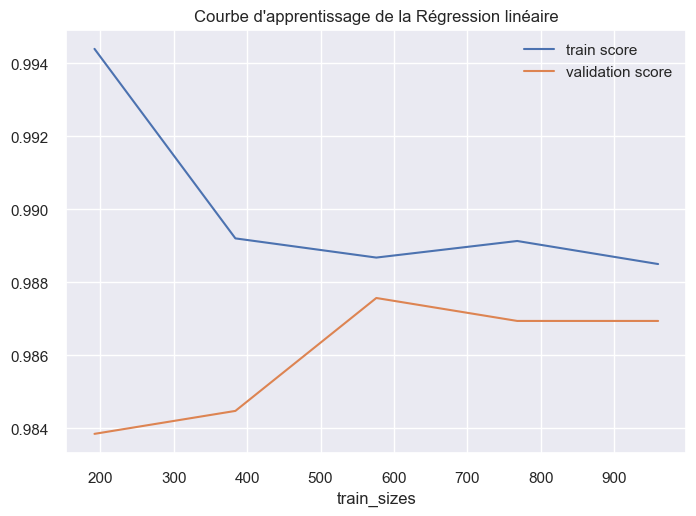

In [303]:
N, train_score, val_score = learning_curve(pipeline_final, X, Y, scoring='balanced_accuracy', train_sizes=np.linspace(0.2, 1.0, 5), cv=5)
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.xlabel('train_sizes')
plt.legend()
plt.title("Courbe d'apprentissage de la Régression linéaire")

Vérifier la courbe d'apprentissage permet de détecter si le modèle est en overfitting et voir si le trainset est de taille suffisant. Ici on remarque qu'un training set de 550 billets étaient suffisant pour obtenir un bon validation score. Nous ne sommes pas dans un cas d'overfitting ou underfitting car la courbe d'apprentissage entre le train set et le testset ne sont pas en sur ou sous apprentissage.

* [sommaire](#sommaire)

#   <a class="anchor" id="V"></a>     V. Prédictions

###   <a class="anchor" id="V.1"></a>     importer le nouveau jeu de données

In [304]:
pipeline_final = pickle.load(open(filename, 'rb'))

In [305]:
nouveau= pd.read_csv("billets_production.csv", sep="," )
nouveau.head(2)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2


* [sommaire](#sommaire)

###   <a class="anchor" id="V.2"></a>     Prédiction sur nouvelles données

####   <a class="anchor" id="V.2.a"></a>     Appliquer sur Kmeans

In [306]:
news = pd.DataFrame(preprocessing.transform(nouveau))

J'ai appliqué le preprocessing pour supprimer les NaN potentiels et les colonnes qui n'étaient pas présentes lors de l'entrainement.

In [307]:
predict = km.predict(news)  # prédiction
decod=Target_encoder.inverse_transform(predict) # Décode le résultat de la prédiction
news= nouveau.assign(is_genuine= decod) # Rajout de la prédiction dans la table
news

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


En appliquant la méthode du Kmeans, il a pu prédire l'authenticité de ces 5 billets grâce aux centroïdes appris lors de l'entrainement. Elle a donc détecté que les 3 premiers billets sont des potentiels faux billets et les 2 derniers des vrais billets.

* [sommaire](#sommaire)

####   <a class="anchor" id="V.2.b"></a>     Appliquer le modèle ML

In [308]:
pipeline_final.predict(nouveau)

array([0, 0, 0, 1, 1])

In [309]:
predictionML(nouveau)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine,probaFaux,probaVrai
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,0.999557,0.000443
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,0.999947,0.000053
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,0.999911,0.000089
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,0.019355,0.980645
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,0.000063,0.999937


En appliquant le modèle de régression Logistique, il a pu prédire l'authenticité de ces 5 nouveaux billets grâce au précédent entrainement. Elle a donc détecté que les 3 premiers billets sont des potentiels faux billets au vu de leur dimensions et les 2 derniers des vrais billets avec une forte probabilité.

* [sommaire](#sommaire)